# Analyse über Einflussfaktoren zum Stromverbrauch im Versorgungsgebiet der CKW AG auf Ebene der Gemeinde
*Business Intelligence and Analytics, MScWI FS24 Hochschule Luzern*
- **Noemi Rohner**
- **Mizgin Turunc**
- **Jan Leuenberger**
- **Lukas Bucheli**


Die CKW AG ist ein zentralschweizer Energieunternehmen, welches sich aufgrund der Energiestrategie 2050 verpflichten musste bis 2027 sämtliche traditionellen Zähler durch Smartmeter zu ersetzen. Sie sollen Teil des Smart Grid werden. Mit einem Smart Grid erhofft man sich eine effizientere Energieversorgung. Die Smartmeter sind ein integrierter Bestandteil des Smart Grid und ermöglichen dadurch neue Funktionen wie intelligente Steuerungen. Besonders durch die aufkommende dezentralisierte Energieerzeugung mit erneuerbaren Energien bei privaten Haushalten, müssen intelligent gesteuert werden, damit das Stromnetz ausbalanciert bleibt. Mit diesen Smartmeter wird auch der Echtzeit-Zugriff auf die Zählerdaten für den Endkunden ermöglicht. Dadurch erhofft sich das Bundesamt für Energie (BFE) einen bewussteren Umgang mit dem Strom und dadurch auch diesen zu sparen (BFE, 2021 [Online-Quelle](https://www.bfe.admin.ch/bfe/de/home/versorgung/stromversorgung/stromnetze/smart-grids.html)).

## Fragestellung
In dieser Arbeit wird folgende Fragestellung versucht zu beantworten:
> Was sind relevante Einflussfaktoren auf Gemeindeebene in Bezug auf den Stromverbrauch im Einzugsgebiet der CKW?

Das wird versucht anhand verschiedener Datensätze welche im Kapitel Datenbank beschrieben sind. Dies sind z.B. Meteo Daten oder demografische Daten.

## Aufbau der Jupyter Notebooks
Aufgrund der umfassenden Datenmenge und dem Einsatz einer SQLite Datenbank wurde entschieden, die Arbeit in mehrere Jupyter Notebooks aufzuteilen:
- **bina_dataimport.ipynb**, In diesem Notebook werden die einzelnen verwendeten Datasets analysiert und in die Datenbank geladen.
- **data_analysis.ipynb**, In diesem Notebook folgt die vernetzte Analyse der Daten.

# Datenquellen und Datenbank
In diesem Notebook werden die Datenquellen beschrieben sowie deren Herkunft. Aufgrund der grossen Datenmengen wird ein Data Warehouse angelegt. Dazu werden die Daten in eine SQLite Datenbank geladen. Dies erlaubt in der späteren Auswertungen vordefinierte Views zu erstellen und diese für die weitere Verwendung zu nutzen.

> !! Dieses Notebook muss zuerst ausgeführt werden, damit die Datenbank erstellt wird. Sie ist zu gross um diese direkt in Github hochzuladen. Die Ausführung erfordert eine lokale Jupyter Instanz in welcher das Github-Repo geklont wird!!

## Eingesetzte Module
Für dieses Notebook werden folgende Module eingesetzt:
- __sqlite3__
    Wird für die Datenbank verwendet
- __pandas__ 
    Wird gebraucht um die CSV Dateien zu lesen und als Dataframe in die SQLite Datenbank zu laden
- __geopandas__
    Wird gebraucht um Geografische Karten darzustellen
- __numpy__
    Wird benötigt um die NaN Werte in den Dataframes mit NULL zu ersetzen
- __glob__
    Wird eingesetzt um gesamte Folders in einem Loop in die SQLite Datenbank zu laden
- __seaborn__
    Wird für Daten-Visualisierungen verwendet. Basiert auf matplotlib
- __matplotlib__
    Wird verwendet für statistische Berechnungen sowie Darstellungen
- __plotly__
    Wird verwendet für statistische Berechnungen sowie Darstellungen
- __math__
    Wir verwendet für mathematische Funktionen

In [ ]:
#Import Modules
import os, sqlite3
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import math

## Datenbank
Zur Untersuchung, welche Einflussfaktoren den Stromverbrauch der Gemeinden im Kanton Luzern beeinflussen können, wird auf mehrere Datenquellen zurückgegriffen. Die Datenquellen sind nachfolgend aufgelistet und werden im weiteren Verlauf beschrieben:
- Smartmeter Daten der CKW AG
- Demografische Daten des Bundes
- Solarkraftwerke Daten des Bundes
- Historische Meteo Daten des Bundes
- Gemeindenamen und BFS-ID von Swisstopo

Die genannten Datenquellen werden mit folgendem ERD in die SQLite Datenbank geladen.

> ![ERD-Diagramm](./DATA/ERD_BINA_V4.png)

Die Erläuterungen, zu den einzelnen Tabellen, folgt bei den jeweiligen Datenimporten.

### Eigenschaften der SQLite Datenbank
Die SQLite Datenbank hat gewisse Einschränkungen und Eigenheiten die beachtet werden müssen. Dies weil SQLite nicht alle Formate oder Datentypen unterstützt. Die relevanten Aspekte werden in diesem Kapitel kurz erläutert.

__Strings__
Damit SQLite die Daten als String erkennt müssen diese in "" eingebettet werden. Ansonsten wird eine Fehlermeldung ausgegeben. Die Datentypen aus den Pandas Dataframes werden nicht in die SQLite Datenbank mitübergeben.

__Datum__
SQLite kennt keinen Datum-Datentyp. Dementsprechend müssen die Datum-/Zeitstempel in einem spezifischen String-Format gespeichert werden. Eine entsprechende Umformung muss daher bereits vor dem Import erfolgen, ansonsten funktionieren die SQLite Datum-/Zeitfunktionen nicht bei den abfragen. Die unterstützten Formate sind in dieser [Dokumentation](https://www.sqlite.org/lang_datefunc.html) gelistet. Für diese Arbeit sind folgende Formate relevant:
- YYYY-MM-DDTHH:MM:SS.SSS 
- YYYY-MM-DD HH:MM

So können Datumabfragen erstellt werden wie im nachfolgenden Beispiel
> `SELECT MAX(strftime('%Y-%m-%d %H:%M', dataTime)) FROM meteoData;`

__Automatische ID__
Damit automatisch ein eindeutiger Primary Key generiert wird muss beim Import der Daten, der Platzhalter für das ID-Attribut leergelassen werden und mit NULL gefüllt werden. So wird automatisch ein Primary Key vergeben.

__No Value Handling__
Leere Werte in den Datenquellen welche mit nan, NaN, na, etc. gelistet sind, müssen mit NULL ersetzt werden. Sonst wird der Wert als String interpretiert und gibt einen Fehler aus, wenn es sich um numerische Werte handelt.

### Erstellen des Datenbank Files
Hier wird die Datenbank angelegt. Ist das File nicht vorhanden, wird dieses automatisch angelegt. Es wird nicht überprüft ob doppelte Daten vorhanden sind.

In [ ]:
# creating file (path) name
dbfile = './DATA/BINA_DATA.db' 

# Test if the database file is available in the colab workspace
if os.path.exists(dbfile):
    # Create database (file) and Open a (SQL) connection 
    connection = sqlite3.connect(dbfile)
    # Create a data cursor to exchange information between Python and SQLite
    cursor = connection.cursor()
else:
    print("Angegebene Database wurde nicht gefunden")
    # Create database (file) and Open a (SQL) connection 
    connection = sqlite3.connect(dbfile)
    # Create a data cursor to exchange information between Python and SQLite
    cursor = connection.cursor()
    #sys.exit(0)


### Tabellen erstellen
Basierend auf dem ERD werden die Tabellen in der Datenbank angelegt. Entsprechend werden die Primary Keys definierte und die Abhängigkeiten referenziert.

In [ ]:
# Tabelle erstellen
sql = ["CREATE TABLE city (id INTEGER PRIMARY KEY, plz string, cityName string, bfsID string, lawCityName string, kantonkuerzel string)",
"CREATE TABLE smartmeter (id INTEGER PRIMARY KEY, plz REFERENCES city(plz) ON UPDATE CASCADE, timestamp string, anzMeter int,valueKwh float)",
"CREATE TABLE solarPlants (id INTEGER PRIMARY KEY, xtfID string, plz string, canton string, totalPower float, mainCategory string, subCategory string, plantCategory string,  _x int,  _y int, FOREIGN KEY (plz) REFERENCES city(plz) ON UPDATE CASCADE, FOREIGN KEY (subCategory) REFERENCES subCategory(id) ON UPDATE CASCADE, FOREIGN KEY (mainCategory) REFERENCES mainCategory(id) ON UPDATE CASCADE, FOREIGN KEY (plantCategory) REFERENCES plantCategory(id) ON UPDATE CASCADE)",
"CREATE TABLE mainCategory (id string PRIMARY KEY, de string, fr string, it string, en string)",
"CREATE TABLE plantCategory (id string PRIMARY KEY, de string, fr string, it string, en string)",
"CREATE TABLE subCategory (id string PRIMARY KEY, de string, fr string, it string, en string)",
"CREATE TABLE indicator (id string PRIMARY KEY, descr string)",
"CREATE TABLE unit (id string,  mes string)",
"CREATE TABLE demoValue (id INTEGER PRIMARY KEY, bfsID string, period string, indicator string, unit string, value float, FOREIGN KEY (bfsID) REFERENCES city(bfsID) ON UPDATE CASCADE, FOREIGN KEY (indicator) REFERENCES indicator (id) ON UPDATE CASCADE, FOREIGN KEY (unit) REFERENCES unit(id) ON UPDATE CASCADE)",
"CREATE TABLE meteoParameter (parameterID string PRIMARY KEY , measure string, description string)",
"CREATE TABLE meteoStations (stn string PRIMARY KEY, stnName string, lawCityName string,  datasource string, bfsID string, coEast string, coNorth string, coLength string, coWide string, FOREIGN KEY (lawCityName) REFERENCES city (lawCityName) ON UPDATE CASCADE, FOREIGN KEY (bfsID) REFERENCES city (bfsID) ON UPDATE CASCADE)",
"CREATE TABLE meteoData (id INTEGER PRIMARY KEY, meteoStation string, meteoParameter string, dataTime string, value float, FOREIGN KEY (meteoStation) REFERENCES meteoStations (stn) ON UPDATE CASCADE, FOREIGN KEY (meteoParameter) REFERENCES meteoParameter (parameterID) ON UPDATE CASCADE)",
"CREATE TABLE meteoParamBfs (id INTEGER PRIMARY KEY, bfsID string, meteoParameter string, meteoStation string, FOREIGN KEY (bfsID) REFERENCES city (bfsID) ON UPDATE CASCADE, FOREIGN KEY (meteoParameter) References meteoParameter (parameterID) ON UPDATE CASCADE, FOREIGN KEY (meteoStation) REFERENCES meteoStations (stn) ON UPDATE CASCADE)",
"CREATE TABLE plzBfsMapping (id INTEGER PRIMARY KEY, plz string, bfsID string, cityName string, lawCityName string)"]

for code in sql:
    cursor.execute(code)
    

### Views erstellen
Diese Views helfen in der späteren Datenanalyse und können direkt in ein Dataframe geladen werden für die weitere Verwendung.

Um einen einfacheren Zugang zu bestimmten Daten zu haben, wurden entsprechende Views generiert. Diese filtern im Beispiel der demografischen Daten die verschiedenen Indikatoren oder verbinden die Daten zwischen mehreren Datensätzen und summieren diese. So können für spätere Auswertungen bereits vorgefertigte Daten verwendet werden.

Folgende Views wurden erstellt:
- **population:** Gibt die Bevölkerung zur BFS-ID in einer bestimmten Periode an.
- **populationDensity:** Gibt die Bevölkerungsdichte zur BFS-ID in einer bestimmten Periode an.
- **areaTotal:** Gibt die Fläche zur BFS-ID in einer bestimmten Periode an.
- **areaSettlement:** Gibt die besiedelte Fläche zur BFS-ID in einer bestimmten Periode an.
- **areaAgricultural:** Gibt die Agrarfläche zur BFS-ID in einer bestimmten Periode an.
- **areaUnproductive:** Gibt die unproduktive Fläche zur BFS-ID in einer bestimmten Periode an.
- **keyFiguresPopulation:** Fasst die einzelnen Datensätze der Bevölkerung und der Bevölkerungsdichte pro BFS-ID und Periode zu einem Datensatz zusammen.
- **keyFiguresArea:** Fasst die einzelnen Datensätze der Fläche pro BFS-ID zu einem Datensatz zusammen, weist aber pro Wert die Periode aus.
- **sumSmartmeter:** Rechnet die KWh pro BFS-ID zusammen.
- **meteoStationsParameter:** Reichert die Daten der Meteo Stationen mit deren Standort an.
- **solarPlantsLU:** Gibt alle registrierten Solaranlagen im Kanton Luzern aus.
- **solarPlantsLUbfsId:** Gibt alle registrierten Solaranlagen im Kanton Luzern aus, gruppiert nach der BFS-ID.
- **sumSunMinutesPerDayBfsId:** Gibt die summierten Sonnenminuten pro Tag und BFS-Nummer aus.
- **sumRainPerDayBfsId:** Gibt den summierten Regen pro Tag und BFS-Nummer aus.
- **avgTempPerDayBfsId:** Gibt die durchschnittliche Temperatur pro Tag und BFS-Nummer aus.

In [ ]:
# Views erstellen
sql = [ "CREATE VIEW population AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_01_01';",
        "CREATE VIEW populationDensity AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_01_03';",
        "CREATE VIEW areaTotal AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_01';",
        "CREATE VIEW areaSettlement AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_02';",
        "CREATE VIEW areaAgricultural AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_04';",
        "CREATE VIEW areaUnproductive AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_07';",
        "CREATE VIEW keyFiguresPopulation as SELECT p.bfsID, p.period, p.value as population, pd.value as populationDensity FROM population p LEFT JOIN population_density pd ON p.bfsID = pd.bfsID AND p.period = pd.period;",
        "CREATE VIEW keyFiguresArea as SELECT a.bfsID, a.period as periodTotal, a.value as total,ase.period as periodSettlement, ase.value as settlement, aa.period as periodAgricultural, aa.value as agricultural, au.period as periodUnproductive, au.value as unproductive FROM areaTotal a LEFT JOIN areaSettlement ase ON a.bfsID = ase.bfsID LEFT JOIN areaAgricultural aa ON a.bfsID = aa.bfsID LEFT JOIN areaUnproductive au ON a.bfsID = au.bfsID;",
        "CREATE VIEW sumSmartmeter as SELECT s.plz as plz, bfsID, SUM(valueKwh) as 'kWh' FROM smartmeter as s LEFT JOIN (SELECT plz, bfsID FROM city GROUP BY plz) as c ON s.plz = c.plz GROUP BY bfsID;",
        "CREATE VIEW meteoStationsParameter as SELECT DISTINCT meteoStations.bfsID, meteoStation, meteoParameter FROM meteoData LEFT JOIN meteoStations on meteoStations.stn = meteoData.meteoStation;",
        "CREATE VIEW solarPlantsLU as SELECT * FROM solarPlants WHERE solarPlants.Canton == 'LU' AND solarPlants.SubCategory == 'subcat_2';",
        "CREATE VIEW solarPlantsLUbfsId as SELECT SUM(s.totalPower), s.canton, p.lawCityName, p.bfsID FROM solarPlants as s LEFT JOIN plzBfsMapping as p ON s.plz = p.plz WHERE s.canton == 'LU' AND s.subCategory == 'subcat_2' GROUP BY p.bfsID;",
        "CREATE VIEW sumSunMinutesPerDayBfsId as SELECT SUM(meteoData.value) as 'Anz. Sonnenminuten pro Tag in min', meteoData.dataTime, meteoData.meteoParameter, meteoParamBfs.bfsID, meteoParamBfs.meteoStation FROM meteoParamBfs LEFT JOIN meteoData ON meteoParamBfs.meteoStation = meteoData.meteoStation WHERE meteoParamBfs.meteoParameter == 'sre000h0' AND meteoData.meteoParameter == 'sre000h0' GROUP BY meteoParamBfs.bfsID, strftime('%Y-%m-%d', meteoData.dataTime);",
        "CREATE VIEW sumRainPerDayBfsId as SELECT SUM(meteoData.value) as 'Regensumme pro Tag in mm', meteoData.dataTime, meteoData.meteoParameter, meteoParamBfs.bfsID, meteoParamBfs.meteoStation FROM meteoParamBfs LEFT JOIN meteoData ON meteoParamBfs.meteoStation = meteoData.meteoStation WHERE meteoParamBfs.meteoParameter == 'rre150h0' AND meteoData.meteoParameter == 'rre150h0' GROUP BY meteoParamBfs.bfsID, strftime('%Y-%m-%d', meteoData.dataTime);",
        "CREATE VIEW avgTempPerDayBfsId as SELECT AVG(meteoData.value) as 'Durchschnittlicher Temperatur pro Tag in Grad Celsius', meteoData.dataTime, meteoData.meteoParameter, meteoParamBfs.bfsID, meteoParamBfs.meteoStation FROM meteoParamBfs LEFT JOIN meteoData ON meteoParamBfs.meteoStation = meteoData.meteoStation WHERE meteoParamBfs.meteoParameter == 'tre000h0' AND meteoData.meteoParameter == 'tre000h0' GROUP BY meteoParamBfs.bfsID, strftime('%Y-%m-%d', meteoData.dataTime);"
       ]

for code in sql:
    cursor.execute(code)

## Datenquellen
Nachfolgend werden die verwendeten Datenquellen beschrieben und ein erstes Mal analysiert.

### BFS-ID Verzeichnis
**Herausgeber:**
Bundesamt für Landestopografie Swisstopo

**Link:**
https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis#Ortschaftenverzeichnis--Download

**Beschreibung:**
Dieses Dataset beinhaltet das amtliche Ortschaftenverzeichnis. Eine Ortschaft ist mit einer eindeutigen Postleitzahl (PLZ) und Ortschaftsnamen bezeichnet. Diese Bezeichnungen sind relevant für die Postadresse und werden durch die Swisstopo erstellt, verwaltet und veröffentlicht (Swisstopo, 2024, [Online-Quelle](https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis)). Die BFS-Nr. wird vom Bundesamt für Statistik (BFS) jeder Gemeinde vergeben. Diese Nummern werden vom BFS erstellt, verwaltet und veröffentlicht. Diese sind im amtlichen Gemeindeverzeichnis ersichtlich (BFS, 2024, [Online-Quelle](https://www.bfs.admin.ch/bfs/de/home/grundlagen/agvch.html)). Dieses Dataset erlaubt die Übersetzung zwischen BFS-Nr. <-> PLZ.

**Zeitraum:**
Das Dataset wurde am 25.3.2024 heruntergeladen. Dementsprechend ist das Dataset auf dem gültigen Stand vom 1.3.2024, da dieses Dataset von Swisstopo immer am ersten Tag im Monat aktualisiert wird (Swisstopo, 2024, [Online-Quelle](https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis)).

**Zweckerfüllung:**
Zur Beantwortung der Forschungsfrage werden diverse Datasets mit einander verbunden. Da die Datasets mit unterschiedlichen Gemeinde-Informationen bzw. Ortschaftsinformationen arbeiten wird eine Übersetzung zwischen der BFS-ID und der PLZ benötigt. Beispielsweise arbeitet das BFS ausschliesslich mit der BFS-ID, die Smartmeter Daten werden auf die PLZ geschlüsselt. Damit die Daten nun miteinander in Beziehung gesetzt werden können, wird dieses Dataset von Swisstopo benötigt. 

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* Da es sich beim Bund um eine Primäre Quelle handelt, ist die Glaubwürdigkeit gegeben.

*Nützlichkeit:* Die Daten sind vollständig und erlauben die notwendige Übersetzung mit einer gewissen Limitierung welche noch genauer erläutert wird.

*Interpretierbarkeit:* Das Dataset ist leicht verständlich und kann ohne weiteres Interpretiert werden.

*Schlüsselintegrität:* Ein eindeutiger Schlüssel ist im Dataset nicht vorhanden.

**Verfügbarkeit:** Das Dataset ist öffentlich verfügbar und kann durch jede Person heruntergeladen werden.

**Preis:** Das Dataset wird kostenlos zu Verfügung gestellt.

#### Inhaltliche Analyse und Schwierigkeiten 
Es sind zehn Spalten in dem CSV Dataset vorhanden mit Total 5733 Zeilen. Die Spalten sind selbstsprechend. Die Spalte "Zusatzziffer" ist eine Post interne Ziffer und ist für die weiterführende Analyse nicht relevant. Auffallend sind die 20 null Werte in der Spalte "Kantonskürzel".
Ortschaft entspricht nicht der Gemeinde und umgekehrt.
- **Ortschaftsname**, Name der Ortschaft
- **PLZ**, Postleitzahl der Ortschaft
- **Zusatzziffer**, Post interne Ziffer
- **Gemeindename**, Gemeindename zu welcher die Ortschaft gehört
- **BFS-Nr**, eindeutige BFS-Nummer
- **Kantonskürzel**, Kürzel des Kantonsnamen
- **E** & **N**, Koordinaten der Ortschaft
- **Sprache**, Lokale Amtssprache
- **Validity**, Gültigkeitsdatum

In [ ]:
# City Daten einlesen als Dataframe und in DB sichern
city_df = pd.read_csv("./DATA/city_directory/AMTOVZ_CSV_LV95.csv", delimiter=";")
city_df.info()

Wie nachfolgend ersichtlich ist, werden die Liechtensteiner Ortschaften ebenfalls in diesem Dataset geführt. Da diese keinem Kanton angehören, sind diese Werte entsprechend leer, daraus resultieren die null Werte.

In [ ]:
df = city_df[city_df['Kantonskürzel'].isnull()]
df.head()

Wenn ein erster Blick auf die ersten Zeilen des Datasets geworfen wird, fällt gleich auf, dass eine PLZ mehrere Ortschaftsnamen haben kann. Umgekehrt kann eine BFS-Nr mehreren Ortschaften mit auch unterschiedlicher PLZ zugewiesen werden. Dies macht die gesamte Übersetzung nicht einfach. Ein weiterer Indikator für diese Schwierigkeit sind die Anzahl eindeutiger Werte bei der PLZ und der BFS-Nr.

In [ ]:
print("Anz. Eindeutige PLZ:",len(city_df['PLZ'].unique()), "\nAnz. Eindeutige BFS-Nr:", len(city_df['BFS-Nr'].unique()))
city_df.head(10)

Besonders gut ersichtlich ist dies mit der Ortschaft/Gemeinde Entlebuch. Diese wird als Ortschaft mit der PLZ 6162 geführt, gehört aber einmal zu der Gemeinde Hasle mit der BFS-Nr. 1005 und einmal zu der eigenständige Gemeinde Entlebuch mit der BFS-Nr. 1002. Aus diesem Grund muss manuell für den Kanton Luzern (auf diesen Kanton beschränken sich die Stromzähler-Daten) eine gültiges Mapping erstellt werden, damit die statistischen Daten korrekt miteinander verknüpft werden können.

In [ ]:
df = city_df.query('Ortschaftsname == "Entlebuch" or Gemeindename == "Entlebuch"')
df.head(100)

Mit den nachfolgenden Codezeilen werden die Daten in die city-Tabelle eingelesen.

In [ ]:
for index, row in city_df.iterrows():
    ort = '"' + row["Ortschaftsname"] + '"'
    lawCityName = '"' + row["Gemeindename"] + '"'
    if isinstance(row["Kantonskürzel"], str):
        kantonkuerzel = '"' + row["Kantonskürzel"] + '"'
    else:
        kantonkuerzel = "NULL"
    sql = "INSERT INTO city VALUES(NULL,{},{},{},{},{})".format(row["PLZ"], ort, row["BFS-Nr"], lawCityName, kantonkuerzel)
    cursor.execute(sql)

connection.commit()

#### Mapping BFS-Nr. <-> PLZ
Um eine eindeutige Zuordnung zwischen PLZ und BFS-Nr zu haben, wurde die Liste der Luzerner Gemeinden händisch bearbeitet. Das Ziel war es jede PLZ eindeutig einer BFS-ID zuzuordnen, wobei aber mehrere verschiedene PLZ auf dieselbe BFS-ID verweisen können. Dazu wurden zuerst sämtliche Gemeinden vom Kanton Luzern aus dem City Directory exportiert. In diesem Datensatz wurden sämtliche, doppelt vorhandenen PLZ identifiziert und geprüft, welches die "Hauptgemeinde" hinder der PLZ darstellt und welche Ortschaften auch bereits mit einer anderen BFS-ID verknüpft sind. Solche Einträge wurden entfernt. Ausser bei einer Ausnahme konnten so sämtliche, doppelten PLZ entfernt werden, wobei darauf geachtet werden musste, dass nicht keine BFS-ID komplett entfernt wird und so keine zugewiesene PLZ mehr hat.

Die Ausnahme bilden Gisikon und Honau, welche zwar identische PLZ (6038) aufweisen, jedoch unterschiedliche BFS-IDs haben. Die BFS-IDs sind einmalig, bedeutet beim Entfernen einer der beiden Datensätze verschwindet eine Markierung auf der Karte. Da anhand der PLZ keine Unterscheidung vorgenommen werden kann, wurde die Entscheidung getroffen, den Datensatz von Honau zu entfernen und nur mit Gisikon zu arbeiten.

Verweisen mehrere PLZ auf dieselbe BFS-ID müssen bei den Auswertungen für die MAP am Ende die Werte zusammengerechnet werden für akkurate Darstellungen.

- **plz**, PLZ der Ortschaft
- **cityName**, Ortschaftsname
- **bfsId**, eindeutige BFS-Nummer für die Ortschaft
- **lawCityName**, Gemeindename


In [ ]:
mapping = pd.read_csv("./DATA/city_directory/mapping_plz_bfsid_lu.csv", delimiter=",")
mapping.info()

In [ ]:

for index, row in mapping.iterrows():
    cityName = '"' + row["cityName"] + '"'
    lawCityName = '"' + row["lawCityName"] + '"'

    sql = "INSERT INTO plzBfsMapping VALUES(NULL,{},{},{},{})".format(row["plz"], row["bfsId"], cityName, lawCityName)
    cursor.execute(sql)

connection.commit()

### Verbaute Solaranlagen
**Herausgeber:**
Bundesamt für Energie (BFE)

**Link:**
https://opendata.swiss/de/dataset/elektrizitatsproduktionsanlagen

**Beschreibung:**
In diesem Dataset sind sämtliche registrierte Elektrizität Produktionsanlagen hinterlegt. Diese Daten basieren auf dem Herkunftsnachweissystem (HKN). In diesem System sind sämtliche Anlagen registriert welche über 30 Kilovoltampere (kVA) bzw. 30 Kilowatt (KW). Zudem sind Kleinanlagen welche über 2 KW produzieren registriert, den Beitreibern steht es aber frei, ob sie sich registrieren möchten. Die Registrierung ist notwendig für einen Herkunftsnachweis. Dieser ist Voraussetzung, wenn Strom in das Netz eingespiesen werden möchte. Es sind nur Anlagen gelistet, welche aktuell in Betrieb sind. Es wird monatlich aktualisiert (BFE, 2024, [Online-Quelle](https://www.uvek-gis.admin.ch/BFE/storymaps/EE_Elektrizitaetsproduktionsanlagen/)).

**Zeitraum:**
Das Dataset wurde am 24.3.2024 heruntergeladen. Dementsprechend ist das Dataset auf dem gültigen Stand vom Monat März, da dieses Dataset vom BFE monatlich aktualisiert wird. Es sind nur aktive Anlagen gelistet (OpenData, 2024, [Online-Quelle](https://opendata.swiss/de/dataset/elektrizitatsproduktionsanlagen)).

**Zweckerfüllung:**
In diesem Dataset befinden sich diverse Kraftwerks-Kategorien. Für diese Arbeit sind besonders die Photovoltaik-Anlagen von Privaten interessant. Dies erschliesst sich daraus, dass mit der Sonne und einer Photovoltaik-Anlage der Strom selbst verbraucht werden kann. Aus Sicht des Energieversorgers sinkt dadurch der Strombedarf und müsste in den Smartmeter-Daten ersichtlich sein. Daher erfüllt dieses Dataset seinen Zweck, in dem des vorhandene Anlagen inkl. verbaute Leistung liefert. Nähere Infos folgen in der tieferen Analyse.

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* Es handelt sich im primäre Daten welche durch das BFE veröffentlicht werden. Dementsprechend ist die Glaubwürdigkeit gegeben. Wie in der Analyse festgestellt wurde, ist die Qualität der Adressen wohl nicht geprüft worden durch eine amtliche Stelle. Wie später beschrieben wird, wurden diverse Schreibfehler und Zahlendreher festgestellt.

*Nützlichkeit:* Die Daten können für den vorgesehenen Zweck verwendet werden. Sie basieren auf aktuellen Daten aus dem HKN. Weiter wird ein Datum des Produktionsbetriebes angegeben, was eine zeitliche Schlussfolgerung zusammen mit den Smartmeter Daten und weiteren Daten zulässt.

*Interpretierbarkeit:* Das Dataset besteht aus sechs CSV-Dateien welche zusammen eine Datenbank in Normalform darstellen. Die Spalten sind klingend benannt. Was nicht intuitiv verständlich ist, sind die drei verschiedenen Kategorie-Katalogen (MainCategoryCatalogue, PlantCategoryCatalogue, SubCategoryCatalogue). Am Aussagekräftigsten ist die SubCategoryCatalogue Datei. Sie gibt direkt an, um welchen erneuerbaren Kraftwerktyp es sich handelt. Die Datei PlantDetail ist nicht relevant, da sie im Dataset nicht referenziert wird. Mit diesem Wissen ist die Interpretierbarkeit gegeben. Nähere Details folgen in der Analyse.

*Schlüsselintegrität:* Die Hauptdatei ist die ElectricityProductionPlant. In dieser ist jedes Kraftwerk mit der xtf_id eindeutig identifizierbar. Jedes Kraftwerk verfügt über mehrere ForeignKey's welche auf die entsprechenden Kategorien geschlüsselt sind. 

**Verfügbarkeit:** Das Dataset ist öffentlich verfügbar und kann durch jede Person heruntergeladen werden.

**Preis:** Das Dataset wird kostenlos zu Verfügung gestellt.

#### Inhaltliche Analyse und Schwierigkeiten 
Die drei relevanten CSV-Dateien MainCategoryCatalogue, PlantCategoryCatalogue und SubCategoryCatalogue sind ausgelagerte Kategorien Definitionen. Diese Dateien sind immer gleich aufgebaut. Zuerst wird die ID angegeben und anschliessend die jeweilige Textbeschreibung in verschiedenen Sprachen (de, fr, it und en). In der PlantCategoryCatalogue Datei werden die detaillierten Kraftwerkstypen angegeben.
- **Catalogue_id**, Katalog ID der Kraftwerkstypen
- **de**, Beschreibung in Deutsch
- **fr**, Beschreibung in Französisch
- **it**, Beschreibung in italienisch
- **en**, Beschreibung in Englisch

In [ ]:
plantCategory = pd.read_csv("./DATA/solar_powerplants/PlantCategoryCatalogue.csv", delimiter=",")
plantCategory.head(100)

Laden der CSV Datei in die SQLite Datenbank.

In [ ]:
for index, row in plantCategory.iterrows():
    catalogueId = '"' + row["Catalogue_id"] + '"'
    de = '"' + row["de"] + '"'
    fr = '"' + row["fr"] + '"'
    it = '"' + row["it"] + '"'
    en = '"' + row["en"] + '"'
    sql = "INSERT INTO plantCategory VALUES({},{},{},{},{})".format(catalogueId, de, fr, it, en)
    cursor.execute(sql)

connection.commit()

Die MainCategoryCatalogue Datei liefert die Haupt-Kraftwerkskategorien. Hier wird unterschieden aus welchem Energieträger Strom produziert wird. Für die vorliegende Arbeit ist die maincat_2 "Übrige erneuerbaren Energien" relevant.
- **Catalogue_id**, Katalog ID der Energieträger
- **de**, Beschreibung in Deutsch
- **fr**, Beschreibung in Französisch
- **it**, Beschreibung in italienisch
- **en**, Beschreibung in Englisch

In [ ]:
mainCategory = pd.read_csv("./DATA/solar_powerplants/MainCategoryCatalogue.csv", delimiter=",")
mainCategory.info()
mainCategory.head()

Laden der CSV Datei in die SQLite Datenbank.

In [ ]:
for index, row in mainCategory.iterrows():
    catalogueId = '"' + row["Catalogue_id"] + '"'
    de = '"' + row["de"] + '"'
    fr = '"' + row["fr"] + '"'
    it = '"' + row["it"] + '"'
    en = '"' + row["en"] + '"'
    sql = "INSERT INTO mainCategory VALUES({},{},{},{},{})".format(catalogueId, de, fr, it, en)
    cursor.execute(sql)

connection.commit()

Wie in der Interpretierbarkeit erläutert ist die SubCategoryCatalogue Datei die aussagekräftigste für diese Arbeit. Mit der subcat_2 ID werden alle Photovoltaik Produktionsanlagen beschrieben.
- **Catalogue_id**, Katalog ID der detaillierten Kraftwerkstypen
- **de**, Beschreibung in Deutsch
- **fr**, Beschreibung in Französisch
- **it**, Beschreibung in italienisch
- **en**, Beschreibung in Englisch

In [ ]:
# Importieren der Unterkategorien
subCategory = pd.read_csv("./DATA/solar_powerplants/SubCategoryCatalogue.csv", delimiter=",")
subCategory.info()
subCategory.head(10)

Laden der CSV Datei in die SQLite Datenbank.

In [ ]:
for index, row in subCategory.iterrows():
    catalogueId = '"' + row["Catalogue_id"] + '"'
    de = '"' + row["de"] + '"'
    fr = '"' + row["fr"] + '"'
    it = '"' + row["it"] + '"'
    en = '"' + row["en"] + '"'
    sql = "INSERT INTO subCategory VALUES({},{},{},{},{})".format(catalogueId, de, fr, it, en)
    cursor.execute(sql)

connection.commit()

Die Hauptdatei ElectricityProductionPlant beinhaltet 203473 Anlagen. Die Datei ist nicht komplett. Die PlantCategory sowie die Koordinaten sind nicht für sämtliche Anlagen gepflegt. Dies stellt für die weitere Analyse kein Problem dar da für jede Anlage eine Adresse mit PLZ und Ortsname verfügbar. Dadurch können diese Kraftwerke direkt einer Smartmeter Gemeinde zugewiesen werden. Die PlantCategory ist sekundär, da die SubCategory relevant ist.
- **xtf_id**, ID des Kraftwerks
- **Address**, Adresse des Kraftwerkes
- **PostCode**, PLZ zu der Adresse
- **Municipality**, Ortschaft zu der PLZ
- **Canton**, Kantonskürzel
- **BeginningOfOperation**, Start der Stromproduktion
- **InitialPower**, Produktionsleistung zum Start des Betriebes in KW
- **TotalPower**, Aktuelle Produktionsleistung in KW
- **MainCategory**, Energieträgerkategorie
- **SubCategory**, Detaillierte Kraftwerkskategorie
- **PlantCategory**, Kraftwerkskategorie
- **_x** & **_y**, Standortkoordinate im LV95 Format

In [ ]:
# Importieren der Solar Kraftanlagen
electricityProductionPlant = pd.read_csv("./DATA/solar_powerplants/ElectricityProductionPlant.csv", delimiter=",")
electricityProductionPlant.info()
electricityProductionPlant.head(10)


Im Kanton Luzern sind 10238 Anlagen registriert. In diesem Subset gibt es ebenfalls Lücken im Bereich der Koordinaten und PlantCategory. Die unten dargestellte Tabelle zeigt die totale Produktionsleistung gruppiert nach den Gemeinden. In dieser Tabelle wird ersichtlich, dass einige Schreibfehler vorhanden sind und dadurch die Gruppierung verfälschen.

In [ ]:
electricityProductionPlantLU = electricityProductionPlant.query('Canton == "LU" and SubCategory == "subcat_2"')
print("\nAnzahl Solaranlagen im Kanton Luzern: ", len(electricityProductionPlantLU), "\n")
electricityProductionPlantLU.info()
electricityProductionPlantLU[["Municipality", "TotalPower"]].groupby('Municipality').sum()


Aufgrund der Schreibfehler wird nach der PLZ gruppiert und in einer eigenen Datenbank View "solarPlantsLUbfsId" die Gemeindenamen sowie die BFS-ID hinzugefügt. Dadurch lassen sich die weiteren Daten miteinander verbinden. Während der Analyse im Zusammenhang mit dem verbinden der PLZ auf die BFS-ID wurde festgestellt, dass die PLZ 6000, 6002, 6011, 6021, 6161 und 6281 in der erstellten Tabelle gefehlt haben. Diese wurden entsprechend manuell nachgepflegt.

In [ ]:
electricityProductionPlantLU[["PostCode", "TotalPower"]].groupby('PostCode').sum()

Während dem weiteren Mapping wurde festgestellt, dass die PLZ 6403 und 6312 nicht zum Kanton Luzern gehören. Wenn diese Einträge genau betrachtet werden, liegt der Verdacht nahe, dass diese Einträge nicht korrekt sind. Die PLZ 6312 wurde wohl falsch eingetippt und könnte 6212 St. Erhard LU sein, da auch die Adresse an diesen Ort verweist. Bei der PLZ 6403 wurde wohl der Kanton falsch angegeben. Diese Werte werden korrigiert aber auf eine weitere Validierung der Adressen wird aus zeitgründen verzichtet. Die Qualität der Daten wird durch die festgestellten Mängel gemindert.

In [ ]:
electricityProductionPlantLU.query('PostCode == 6403 or PostCode == 6312')
electricityProductionPlant.at[101656, 'PostCode'] = 6212
electricityProductionPlant.at[138741, 'Canton'] = 'SZ'

In [ ]:
electricityProductionPlant.query('xtf_id == 168209 or xtf_id == 218255')

Wenn man nun die Dichte der Kraftwerke anschaut, fällt auf, dass die Ausreiser den gesamten Boxplot verzerren. Aus diesem Grund werden die Anlagen welche als Kleinanlage klassifiziert sind (kleiner 30 KW) separat betrachtet sowie die grösseren Anlagen. Im Schnitt hat jede Anlage eine Produktionsleistung von 35,43 KW im Kanton Luzern. Die kleinste registrierte Anlage hat eine Leistung von 0.2 KW. Die grösste Anlage steht in Perlen und hat eine Produktionsleistung von 6425 KW.

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot(electricityProductionPlantLU['TotalPower'])
plt.ylabel('Installierte Produktionsleistung Total Power (KW)')
plt.title('Boxplot der installierten Photovoltaikanlagen im Kanton Luzern')
electricityProductionPlantLU['TotalPower'].describe()

Im Bereich der Kleinanlagen sind die Grenzen nun klar ersichtlich. 8076 Kleinanlagen sind im Kanton Luzern registriert. Jede davon besitzt im Schnitt eine Produktionsleistung von 14.4 KW. Bei den Grossanlagen sind es 2162 registrierte Anlagen, bei der jede im Schnitt eine Produktionsleistung von 114 KW besitzt. Die grösste Anlage hat eine Produktionsleistung von 6425 KW. Bei der Betrachtung der Histogramme wird ersichtlich, dass es bei den Kleinanlagen zwei Spitzen gibt. Eine ist ca. bei 10 KW Produktionsleistung und die zweite bei 30 KW Produktionsleistung. Bei den Grossanlagen ist ein rechtschiefes Histogramm erkennbar. Somit sind die Kleineren Anlagen in der Überzahl und je höher die Produktionsleistung ist, desto kleiner ist die Anzahl an Anlagen.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle('Vergleich Kleinanlagen (<30 KW) und Grossanlagen (>30 KW)')
df_small = electricityProductionPlantLU.query('TotalPower <= 30')
sns.boxplot(ax = axes[0, 0], data=df_small, x='TotalPower').set(title='Boxplot Kleinanlagen <= 30 KW', xlabel='Installierte Produktionsleistung (KW)')
sns.histplot(ax = axes[1, 0], data=df_small, x='TotalPower').set(title='Histogram Kleinanlagen <= 30 KW', xlabel='Installierte Produktionsleistung (KW)', ylabel='Anzahl installierter Anlagen')
df_large = electricityProductionPlantLU.query('TotalPower > 30')
sns.boxplot(ax = axes[0, 1], data=df_large, x='TotalPower').set(title='Boxplot Grossanlagen > 30 KW', xlabel='Installierte Produktionsleistung (KW)')
sns.histplot(ax = axes[1, 1], data=df_large, x='TotalPower').set(title='Histogram Grossanlagen > 30 KW', xlabel='Installierte Produktionsleistung (KW)', ylabel='Anzahl installierter Anlagen')
plt.show()


In [ ]:
print('Statistische Übersicht Kleinanlagen: \n', df_small['TotalPower'].describe(), '\nStatistische Übersicht Grossanlagen: \n',df_large['TotalPower'].describe())

Wenn man auf Gemeinde Ebene die Anzahl Anlagen betrachtet (Klein- und Grossanlagen), wird ersichtlich, dass Hitzkirch die meisten registrierten Anlagen besitzt. Danach folgen Horw und Meggen bevor ein Platteau folgt, angeführt von Ruswil.

In [ ]:
df_plz = pd.merge(electricityProductionPlantLU, mapping, left_on='PostCode', right_on='plz')
df_plzBfs = pd.DataFrame(df_plz['xtf_id'].groupby(df_plz['lawCityName']).count()).sort_values(['xtf_id'], ascending=False)
df_plzBfs.head()
plt.figure(figsize=(20,5))
sns.barplot(df_plzBfs, x='lawCityName', y='xtf_id').set(title = 'Anzahl Photovoltaikanlagen pro Gemeinde', xlabel='Gemeinde', ylabel='Anzahl Anlagen')
plt.xticks(rotation=90)
plt.show()

Bei der Betrachtung der gesamthaften Produktionsleistung pro Gemeinde gibt es jeweils Verschiebungen, wenn die Grossanlagen und Kleinanlagen getrennt betrachtet werden.

In [ ]:
df_plz = pd.merge(electricityProductionPlantLU, mapping, left_on='PostCode', right_on='plz')
df_plzBfs = pd.DataFrame(df_plz['TotalPower'].groupby(df_plz['lawCityName']).sum()).sort_values(['TotalPower'], ascending=False)
df_plzBfs.head()

df_small = electricityProductionPlantLU.query('TotalPower <= 30')
df_smallPlz = pd.merge(df_small, mapping, left_on='PostCode', right_on='plz')
df_smallPlzBfs = pd.DataFrame(df_smallPlz['TotalPower'].groupby(df_smallPlz['lawCityName']).sum()).sort_values(['TotalPower'], ascending=False)

df_large = electricityProductionPlantLU.query('TotalPower > 30')
df_largePlz = pd.merge(df_large, mapping, left_on='PostCode', right_on='plz')
df_largePlzBfs = pd.DataFrame(df_largePlz['TotalPower'].groupby(df_largePlz['lawCityName']).sum()).sort_values(['TotalPower'], ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(df_plzBfs, x='lawCityName', y='TotalPower').set(title = 'Produktionsleistung der Photovoltaikanlagen pro Gemeinde', xlabel='Gemeinde', ylabel='Produktionsleistung (KW)')
plt.xticks(rotation=90)

plt.figure(figsize=(20,5))
sns.barplot(data=df_smallPlzBfs, x='lawCityName', y='TotalPower').set(title='Kleinanlagen <= 30 KW', xlabel='Gemeinde', ylabel='Produktionsleistung (KW)')
plt.xticks(rotation=90)

plt.figure(figsize=(20,5))
sns.barplot(data=df_largePlzBfs, x='lawCityName', y='TotalPower').set(title='Grossanlagen > 30 KW', xlabel='Gemeinde', ylabel='Produktionsleistung (KW)')
plt.xticks(rotation=90)

plt.show()

Für eine geografische Darstellung müssen die Gemeindegrenzen werden von einer externen Quelle geladen. Die Grenzen werden als Multipolygone auf der Karte eingezeichnet.
- **gemeinde.BFS_NUMMER**, eindeutige BFS-Nummer
- **gemeinde.NAME**, Gemeindename
- **kanton.KUERZEL**, Kantons-Kürzel
- **kanton.NAME**, Name des Kantons
- **geometry**, Geometrie-Objekt mit einer Sammlung von Multipolygonen zur Beschreibung der Gemeindegrenzen

In [ ]:
# read Swiss Cantons Geometry Data (as GeoFrame)
geofilePATH = 'https://raw.githubusercontent.com/sawubona-repo/BINA-FS24-WORK/master/zDiversExamples/Notebook-GeoMapping/DATA/'
geofileNAME = 'ch-municipalities.geojson'

# Read GeoJSON geometry data into geopandas GeoDataFrame
raw_geodf = gpd.read_file(geofilePATH+geofileNAME)

raw_geodf.info()

Bei einer Betrachtung auf der Karte des Kanton Luzern, erkennt man keine Muster.

In [ ]:
df = pd.merge(df_plzBfs, mapping, left_on='lawCityName', right_on='lawCityName', how='left').drop_duplicates(subset=['lawCityName'])
joined_geodf = pd.merge(raw_geodf, df, left_on="gemeinde.BFS_NUMMER", right_on="bfsId")
joined_geodf.head()

map_center = dict(lat=47.07084, lon=8.23502)
map_zoom = 8.0

fig = px.choropleth_mapbox(
    joined_geodf,
    geojson=joined_geodf.geometry,
    locations=joined_geodf.index,
    color='TotalPower',                                   # define feature variable
    color_continuous_scale=px.colors.diverging.Geyser,           # define color palette
    labels={'lawCityName': 'Gesamthafte Produktionsleistung pro Gemeinde'},
    hover_name='gemeinde.NAME',                                       # define mouse over infos
    hover_data={'TotalPower':True},
    opacity=0.5,
    center=map_center,                      # set capital Bern as map center
    zoom=map_zoom,
    mapbox_style="carto-positron"                                # other option "open-street-map"
)

fig.update_layout(title_text='Übersicht der installierten Produktionsleistung pro Gemeinde in KW')

fig.show()

Mit diesen Anpassungen und Erkenntnissen können die Daten in die Datenbank geladen werden. Weiter und tiefere Analyse folgen in den weiteren Schritten.
Vor dem Import werden die na Werte noch mit NULL überschrieben, damit die SQLite Datenbank diese als solche versteht.

In [ ]:
electricityProductionPlant.replace(np.nan, "NULL", inplace=True)
for index, row in electricityProductionPlant.iterrows():
    mainCategoryId = '"' + row["MainCategory"] + '"'
    subCategoryId = '"' + row["SubCategory"] + '"'
    canton = '"' + row["Canton"] + '"'
    xCor = row["_x"]
    yCor = row["_y"]
    
    if isinstance(row["PlantCategory"], str):
        plantCategoryId = '"' + row["PlantCategory"] + '"'
    else:
        plantCategoryId = "NULL"
        
    sql = "INSERT INTO solarPlants VALUES(NULL,{},{},{},{},{},{},{},{},{})".format(row["xtf_id"], row["PostCode"], canton, row["TotalPower"], mainCategoryId, subCategoryId, plantCategoryId, xCor, yCor)
    cursor.execute(sql)
    
connection.commit()

### Demografische Daten
**Herausgeber:**
Bundesamt für Statistik (BFS)

**Link:**
[Daten](https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken/tabellen.assetdetail.16484444.html)
[Indikator-Beschreibungen](https://dam-api.bfs.admin.ch/hub/api/dam/assets/16484444/appendix)


**Beschreibung:**
Dieses Dataset wird vom Bundesamt für Statistik zu Verfügung gestellt und beinhaltet diverse demografische Daten zu den Gemeinden. Dazugehören z.B. Indikatoren zu den Themen Bevölkerung, Flächen, Wirtschaft, Bau- und Wohnungswesen, soziale Sicherheit sowie Wähleranteile ausgewählter Parteien (BFS, 2021, [Online-Quelle](https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken/tabellen.assetdetail.16484444.html)).

**Zeitraum:**
Der Zeitraum der Daten liegt zwischen 2004-2020 (BFS, 2021, [Online-Quelle](https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken/tabellen.assetdetail.16484444.html))

**Zweckerfüllung:**
Diese Demografische Daten erfüllen den Zweck im Sinne, dass mögliche Faktoren gefunden werden können, die den Stromverbrauch beeinflussen.

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:*
Beim Bundesamt für Statistik handelt es sich um eine primäre Quelle. Diese erheben und bearbeiten die Daten. Aus diesem Grund ist die Glaubwürdigkeit gegeben. 

*Nützlichkeit:* 
Die Daten stammen hauptsächlich aus dem Jahr 2019 und sind somit bereits 5 Jahre alt. Aufgrund mangelnder Alternativen, werden diese Daten verwendet. Es wird angenommen, dass die Entwicklungen nicht signifikant anders sind und deshalb der Nutzen trotzdem gegeben ist.

*Interpretierbarkeit:* 
Die Daten werden in einer normalisierten Form zu Verfügung gestellt. Somit müssen diese Daten zusammengefügt werden, damit sie interpretiert werden können. Durch die beschreibenden Indikatoren und Masseinheiten, können die Daten gut gelesen werden.

*Schlüsselintegrität:* 
Einen Primary Key gibt es nicht. Dieser muss generiert werden beim Import in die Datenbank. Als Foreign Key wird die BFS-Nummer verwendet sowie die Indikatoren Beschreibung und Masseinheit. Für jede Zeile wird die Kombination aus der BFS-Nummer, gemessener Indikator und Masseinheit angegeben. Dies jür jede Gemeinde.

**Verfügbarkeit:** 
Die Daten sind öffentlich verfügbar und können unter der Einhaltung der [OPEN-BY-ASK](https://www.bfs.admin.ch/bfs/de/home/bfs/bundesamt-statistik/nutzungsbedingungen.html) Bedingungen genutzt werden. Diese erlauben eine freie Nutzung, lediglich für eine kommerzielle Nutzung wird eine Bewilligung benötigt und die Quelle muss angegeben werden (BFS, 2021, [Online-Quelle](https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken/tabellen.assetdetail.16484444.html)).

**Preis:** 
Die Daten sind kostenlos verfügbar.

#### Inhaltliche Analyse und Schwierigkeiten 
Die CSV-Datei ts-x-21.03.01 ist die zentrale Datei. Diese beinhaltet die demografischen Daten inkl. den Referenzen auf die Indikator-Beschreibung (indicator_DemoData) und Masseinheit (unit_mes_DemoData). Diese beschreibenden Elemente können aus der separaten ODS-Datei ts-x-21.03.01-APPENDIX als CSV-Datei extrahiert werden. Die Indikator Datei besteht aus zwei Spalten. Insgesamt werden 41 Indikatoren geliefert und diese sind vollständig beschrieben. Wichtig anzumerken ist, dass die Masseinheit zu der Gesamtfläche nicht korrekt ist. In den CSV-Dateien wird diese mit m2 angegeben. In den Datenbeschreibungen wird aber explizit erwähnt, dass die Gesamtfläche in km2 angegeben ist.
- **INDICATORS**, Indikator-ID (Primary Key)
- **DE**, die Deutsche Beschreibung des Indikators

Für die zu untersuchende Fragestellung eignen sich besonders folgende Indikatoren:
- **Ind_01_01**, Bevölkerung - Einwohner
- **Ind_01_03**, Bevölkerung - Bevölkerungsdichte
- **Ind_01_13**, Bevölkerung - Anzahl Privathaushalte
- **Ind_01_14**, Bevölkerung - Durchschnittliche Haushaltsgrösse
- **Ind_04_01**, Fläche - Fläche, Total in km2
- **Ind_04_02**, Fläche - Siedlungsflächen %
- **Ind_04_04**, Fläche - Landwirtschaftsflächen %
- **Ind_04_06**, Fläche - Wald und Gehölze %
- **Ind_06_03**, Wirtschaft - Beschäftigte, Total
- **Ind_06_07**, Wirtschaft - Arbeitsstätten, Total

Mit diesen Indikatoren wird zu einem späteren Zeitpunkt versucht, ein Zusammenhang darzustellen.

In [ ]:
#Importieren Demografie Daten Indikator
demoIndicator = pd.read_csv("./DATA/key_figures_communities/Indicator_DemoData.csv", delimiter=";")
demoIndicator.info()
demoIndicator.head(45)

Mit diesen Code-Zeilen werden die Daten in die Datenbank eingelesen.

In [ ]:

for index, row in demoIndicator.iterrows():
    indicatorId = '"' + row["INDICATORS"] + '"'
    de = '"' + row["DE"] + '"'
    
    sql = "INSERT INTO indicator VALUES({},{})".format(indicatorId, de)
    cursor.execute(sql)
    
connection.commit()

Aus der Datei unit_mes_DemoData werden die Masseinheiten ausgelesen. Insgesamt sind neun Einheiten erforderlich und diese sind vollständig beschrieben.
- **UNIT_MES**, Masseinheit ID (Primary Key)
- **Einheit**, Einheit-Bezeichnung

In [ ]:
#Importieren Unit Messeinheit
unitMeas = pd.read_csv("./DATA/key_figures_communities/unit_mes_DemoData.csv", delimiter=";")
unitMeas.info()
unitMeas.head()

Hier werden die Daten in die Datenbank geladen.

In [ ]:
for index, row in unitMeas.iterrows():
    unitMeasId = '"' + row["UNIT_MES"] + '"'
    unit = '"' + row["Einheit"] + '"'
    
    sql = "INSERT INTO unit VALUES({}, {})".format(unitMeasId, unit)
    cursor.execute(sql)

connection.commit()

Die Hauptdatei ts-x-21.03.01 beinhaltet sämtliche Daten. Die Schwierigkeit liegt in der Mischung der verschiedenen Indikatoren und dem dazugehörigen Zeiträumen. Die Zeiträume müssen als String gesichert werden, da z.T. zwei Jahreszahlen angegeben sind. Bei der BFS-Nummer ist ersichtlich das die Schweiz als CH hinterlegt ist. Damit alles als Integer behandelt werden kann, wird CH in 0 umgeschrieben. Von den 89093 Zeilen sind bei der Spalte Vergleich Zeitraum nur 4346 Daten vorhanden. Da die Vergleiche in dem vorliegenden Kontext nicht relevant sind, können diese ignoriert werden. Es fällt noch auf, dass bei den VALUE 4148 Daten fehlen. Wenn man diese fehlende Daten betrachtet erkennt man das dies mit dem Status zusammenhängt. Ein Blick auf die Metadaten-Beschreibung gibt Aufschluss darüber. Daten die mit M gekennzeichnet sind, entfallen, weil trivial oder Begriffe nicht anwendbar. Der Status Q bedeutet, Entfällt aus Datenschutzgründen. Daher können auch diese Daten ignoriert werden. Der Status wird aus diesem Grund nicht in die Datenbank importiert. Der Vergleichszeitraum ist für diese Arbeit nicht verwendbar. Die Daten stammen aus dem Jahr 2019 und die Smartmeter Daten werden erst seit 2020 erfasst. Daher ergibt sich keine Überschneidung und ermöglicht daher keine Untersuchung über die Zeit im Zusammenhang mit dem Stromverbrauch.
- **PERIOD_REF**, Messzeitraum
- **PERIOD_COMP**, Vergleichszeitraum
- **CODE_REGION**, BFS-Nummer
- **INDICATORS**, Indikator-ID (Foreign-Key)
- **UNIT_MES**, Masseinheit-ID (Foreign-Key)
- **VALUE**, Wert
- **STATUS**, Status des Messwertes

In [ ]:
#Importieren demoValue
demoValue = pd.read_csv("./DATA/key_figures_communities/ts-x-21.03.01.csv", delimiter=";", dtype={'PERIOD_REF': str, 'PERIOD_COMP': str, 'REGION': str})

demoValue.info()
demoValue.head()

print("\nEindeutige Werte des Messzeitraumes: ", demoValue['PERIOD_REF'].unique())
print("\nEindeutige Werte des vergleich Zeitraumes: ", demoValue['PERIOD_COMP'].unique())
demoValue[['VALUE']].isna().groupby(demoValue['STATUS']).sum()

Für eine weitere Analyse im Kanton Luzern wird ein Dataset zusammengestellt mit sämtlichen Indikatoren für den Kanton Luzern. Ein Kurzer Quercheck zeigt, dass die Daten vollständig sind.
> 41 Indikatoren x 80 Luzerner Gemeinden = 3280 Werte.

In [ ]:
demoValue.replace("CH", 0, inplace=True)
df_demo = demoValue.astype({'CODE_REGION': str})
df_city = city_df.astype({'BFS-Nr': str})
df_city.drop(columns=['Ortschaftsname', 'PLZ', 'Zusatzziffer', 'Gemeindename', 'E', 'N', 'Sprache', 'Validity'], inplace=True)
df_base = pd.merge(df_demo, df_city, left_on='CODE_REGION', right_on='BFS-Nr', how='left')
df_base.drop_duplicates(subset=['PERIOD_REF', 'PERIOD_COMP', 'CODE_REGION', 'INDICATORS', 'UNIT_MES', 'VALUE'], keep='first', inplace=True)
df_base.rename(columns={'Kantonskürzel': 'Kantonskuerzel'}, inplace=True)
df_baseLU = df_base.query('Kantonskuerzel == "LU"')
df_baseLU.info()

Wenn man die Bevölkerungsverteilung im Kanton Luzern betrachtet, stellt man fest, dass im Schnitt jede Gemeinde eine Bevölkerungsgrösse von 5164 hat. Spannend ist zu sehen, dass 75% der Gemeinden weniger als 4877 Einwohner:innen hat. Dies bestätigen auch das folgenden Rechtsschiefe Histogram und der Boxplot mit den grossen Outlier die gegen die 80'000 gehen. Insgesamt sind im Kanton Luzern 413120 Einwohner:innen registriert.

In [ ]:
df = df_baseLU.query('INDICATORS == "Ind_01_01"').sort_values(by=['VALUE'], ascending=False)
print("Anzahl Einwohner im Kanton Luzern: ", df['VALUE'].sum())
df['VALUE'].describe()

In [ ]:
fig, axes = plt.subplots(2, figsize=(20,10))
fig.suptitle('Analyse der Bevölkerungsgrösse im Kanton Luzern')
sns.boxplot(ax = axes[0], data=df_baseLU, x='VALUE').set(title='Boxplot Bevölkerungsgrösse Kt. LU', xlabel='Anzahl Einwohner*innen')
sns.histplot(ax = axes[1], data=df_baseLU, x='VALUE').set(title='Histogram Bevölkerungsgrösse Kt. LU', xlabel='Anzahl Einwohner*innen')
plt.show()

Wenn man die Gemeinden miteinander vergleicht, werden die Ausreisser nach oben namentlich ersichtlich. Luzern ist mit Abstand die grösste Gemeinde. Danach folgen die grösseren Gemeinden Emmen und Kriens.

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(df, x='REGION', y='VALUE').set(title = 'Vergleich der Bevölkerungsgrösse', xlabel='Gemeinde', ylabel='Anz. Einwohner*innen')
plt.xticks(rotation=90)
plt.show()

Für weitere Analyse unter den verschiedenen Indikatoren, werden diese in eigenständige Dataframes geladen.

In [ ]:
df_people = df_baseLU.query('INDICATORS == "Ind_01_01"').sort_values(by=['VALUE'], ascending=False)
df_households = df_baseLU.query('INDICATORS == "Ind_01_13"').sort_values(by=['VALUE'], ascending=False)
df_households.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_households.rename(columns={'VALUE': 'anzHaushalte'}, inplace=True)
df_avgHouseholds = df_baseLU.query('INDICATORS == "Ind_01_14"').sort_values(by=['VALUE'], ascending=False)
df_avgHouseholds.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_avgHouseholds.rename(columns={'VALUE': 'avgMenschenHaushalt'}, inplace=True)
df_area = df_baseLU.query('INDICATORS == "Ind_04_01"').sort_values(by=['VALUE'], ascending=False)
df_area.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_area.rename(columns={'VALUE': 'Flaeche'}, inplace=True)
df_areaHome = df_baseLU.query('INDICATORS == "Ind_04_02"').sort_values(by=['VALUE'], ascending=False)
df_areaHome.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_areaHome.rename(columns={'VALUE': 'Siedlungsflaeche'}, inplace=True)
df_areaLand = df_baseLU.query('INDICATORS == "Ind_04_04"').sort_values(by=['VALUE'], ascending=False)
df_areaLand.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_areaLand.rename(columns={'VALUE': 'Landwirtschaftflaeche'}, inplace=True)
df_areaForest = df_baseLU.query('INDICATORS == "Ind_04_06"').sort_values(by=['VALUE'], ascending=False)
df_areaForest.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_areaForest.rename(columns={'VALUE': 'Waldflaeche'}, inplace=True)
df_ecoLabor = df_baseLU.query('INDICATORS == "Ind_06_03"').sort_values(by=['VALUE'], ascending=False)
df_ecoLabor.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_ecoLabor.rename(columns={'VALUE': 'Arbeitstaetige'}, inplace=True)
df_ecoComp = df_baseLU.query('INDICATORS == "Ind_06_04"').sort_values(by=['VALUE'], ascending=False)
df_ecoComp.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'REGION', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_ecoComp.rename(columns={'VALUE': 'Arbeitsstaetten'}, inplace=True)

Beim Vergleich der Bevölkerungsgrösse mit den Anzahl Haushalten ist erkennbar, dass je grösser die Bevölkerung der Gemeinde ist, desto mehr Haushalte hat diese. Mit einer Korrelation von 0.99 werden die Daten sehr gut, durch die gezeichnete Gerade beschrieben.

In [ ]:
plt.figure(figsize=(10,5))
df = pd.merge(df_people, df_households, on='CODE_REGION')
df.head()
sns.regplot(x=df['VALUE'], y=df['anzHaushalte'], ci=None, line_kws={"color": "red"}).set(xlabel='Anz. Einwohner:innen', ylabel='Anz. Haushalte')
plt.title("Bevölkerungsgrösse vs. Anz. Haushalten")
plt.show()

In [ ]:
print(df['VALUE'].corr(df['anzHaushalte']))

Für eine schneller Übersicht über alle Indikatoren, werden diese in ein einzelnes Dataframe geladen.

In [ ]:
df_all = pd.merge(df_people, df_households, on='CODE_REGION')
df_all = pd.merge(df_all, df_avgHouseholds, on='CODE_REGION')
df_all = pd.merge(df_all, df_area, on='CODE_REGION')
df_all = pd.merge(df_all, df_areaHome, on='CODE_REGION')
df_all = pd.merge(df_all, df_areaLand, on='CODE_REGION')
df_all = pd.merge(df_all, df_areaForest, on='CODE_REGION')
df_all = pd.merge(df_all, df_ecoLabor, on='CODE_REGION')
df_all = pd.merge(df_all, df_ecoComp, on='CODE_REGION')
df_all.rename(columns={'VALUE': 'anzEinwohner'}, inplace=True)
df_all.drop(columns=['PERIOD_REF', 'PERIOD_COMP', 'INDICATORS', 'UNIT_MES', 'STATUS', 'BFS-Nr', 'Kantonskuerzel'], inplace=True)
df_all.head()

Auf der unten dargestellten Heatmap werden die Korrelationen zwischen den einzelnen Parametern gut ersichtlich. Man kann feststellen, dass je mehr Einwohner:innen in der Gemeinde beheimatet sind mehr Haushalte, merh Arbeitstaetige und mehr Siedlungsfläche vorhanden sind. Interessant ist ebenfalls der Zusammenhang zwischen der Gesamtfläche und den Waldflächen sowie Landwirtschaftsflächen. Je höher die Gesamtfläche ist, desto höher sind ebenfalls die vorher genannten Flächen.

In [ ]:
df_all['absSiedlungsflaeche'] = df_all.Flaeche * (df_all.Siedlungsflaeche/100)
df_all['absLandwirtschaftflaeche'] = df_all.Flaeche * (df_all.Landwirtschaftflaeche/100)
df_all['absWaldflaeche'] = df_all.Flaeche * (df_all.Waldflaeche/100)
df_figure = df_all.drop(columns=['CODE_REGION', 'REGION'])
sns.heatmap(df_figure.corr(), annot=True)
plt.show()

In dem nachfolgenden Pairplot kann überprüft werden wie gut die Korrelationen wirklich zu den Punkten passen.

In [ ]:
sns.pairplot(df_figure, kind='reg', plot_kws={'line_kws':{'color':'red'}})

In der nachfolgenden Karte wird der prozentuale Anteil von Landwirtschaftsflächen dargestellt. Es wird ersichtlich das rund um Luzern der Anteil gering ist. Dasselbe gilt im Amt Entlebuch dort sind die Landwirtschaftliche Flächen anteilsmässig gering. Dafür spielt die Landwirtschaft in den Ämtern Willisau, Hochdorf und Sursee eine grössere Rolle.

In [ ]:
df_all.rename(columns={'CODE_REGION':'gemeinde.BFS_NUMMER'}, inplace=True)

In [ ]:
df_map = df_all.astype({'gemeinde.BFS_NUMMER':int})
joined_geo = pd.merge(raw_geodf, df_map, on='gemeinde.BFS_NUMMER', how='left')
joined_geo.head()

In [ ]:
fig = px.choropleth_mapbox(
    joined_geo,
    geojson=joined_geo.geometry,
    locations=joined_geo.index,
    color='Landwirtschaftflaeche',                                   # define feature variable
    color_continuous_scale=px.colors.diverging.Geyser,           # define color palette
    labels={'REGION': 'Anteil Landwirtschaftsfläche'},
    hover_name='gemeinde.NAME',                                       # define mouse over infos
    hover_data={'Siedlungsflaeche':True, 'Landwirtschaftflaeche':True, 'Waldflaeche':True},
    opacity=0.5,
    center=map_center,                      # set capital Bern as map center
    zoom=map_zoom,
    mapbox_style="carto-positron"                                # other option "open-street-map"
)

fig.update_layout(title_text='Anteil der Landwirtschaftsflächen in %')

fig.show()

Bei der Betrachtung der prozentualen Siedlungsfläche ist diese im Amt Entlebuch sehr gering. Die Region Luzern und Sursee stechen hier hervor mit anteilsmässigen höheren Werten.

In [ ]:
fig = px.choropleth_mapbox(
    joined_geo,
    geojson=joined_geo.geometry,
    locations=joined_geo.index,
    color='Siedlungsflaeche',                                   # define feature variable
    color_continuous_scale=px.colors.diverging.Geyser,           # define color palette
    labels={'REGION': 'Anteil Landwirtschaftsfläche'},
    hover_name='gemeinde.NAME',                                       # define mouse over infos
    hover_data={'Siedlungsflaeche':True, 'Landwirtschaftflaeche':True, 'Waldflaeche':True},
    opacity=0.5,
    center=map_center,                      # set capital Bern as map center
    zoom=map_zoom,
    mapbox_style="carto-positron"                                # other option "open-street-map"
)

fig.update_layout(title_text='Anteil der Siedlungsflaeche in %')

fig.show()

Bei der Betrachtung der Waldfläche, sticht das Amt Entlebuch stark hervor. Die anderen Regionen sind sich ähnlich.

In [ ]:
fig = px.choropleth_mapbox(
    joined_geo,
    geojson=joined_geo.geometry,
    locations=joined_geo.index,
    color='Waldflaeche',                                   # define feature variable
    color_continuous_scale=px.colors.diverging.Geyser,           # define color palette
    labels={'REGION': 'Anteil Landwirtschaftsfläche'},
    hover_name='gemeinde.NAME',                                       # define mouse over infos
    hover_data={'Siedlungsflaeche':True, 'Landwirtschaftflaeche':True, 'Waldflaeche':True},
    opacity=0.5,
    center=map_center,                      # set capital Bern as map center
    zoom=map_zoom,
    mapbox_style="carto-positron"                                # other option "open-street-map"
)

fig.update_layout(title_text='Anteil der Waldflaeche in %')

fig.show()

Damit die Daten ohne Fehler in die SQLite Datenbank importiert werden können, wird CH durch eine 0 ersetzt und alle Null Werte durch den String NULL ersetzt.

In [ ]:
demoValue.replace(np.nan, "NULL", inplace=True)

In [ ]:
for index, row in demoValue.iterrows():
    period = row["PERIOD_REF"]
    if isinstance(period, str):
        period = '"' + period + '"'
    else:
        period = str(period)
        period = '"' + period + '"'
        
    indicator = '"' + row["INDICATORS"] + '"'
    unit = '"' + row["UNIT_MES"] + '"'
    
    sql = "INSERT INTO demoValue VALUES(NULL,{},{},{},{},{})".format(row["CODE_REGION"], period, indicator, unit, row["VALUE"])
    cursor.execute(sql)
    
connection.commit()

### Smartmeter Daten Kanton Luzern
**Herausgeber:**
CKW AG

**Link:**
https://www.ckw.ch/landingpages/open-data

**Beschreibung:**
Beim Datensatz aggregierte Smart Meter handelt es sich um aggregierte Verbräuche nach Gemeinden im Versorgungsgebiet der CKW. Die Aggregation wurde auf Stufe Postleitzahl angewendet. In einer zusätzlichen Spalte sind die Anzahl Smartmeter für die aggregierte Sicht aufgelistet. Grossverbraucher*innen wurden aus dem Datensatz entfernt, damit keine Rückschlüsse auf einzelne Grossverbraucher*innen gemacht werden können (CKW AG, 2024, [Online-Quelle](https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/index.html#dataset-b)). 

**Zeitraum:**
Die Smartmeter Daten wurden für den Zeitraum vom 2020-12-30 00:00 - 2024-03-06 23:00 geladen.

**Zweckerfüllung:**
Die Smartmeter Daten liefern die Grundlage für die vorliegende Untersuchung. Es steht der aggregierte Verbrauch pro Ortschaft im 15min Takt zu Verfügung. Damit lassen sich Vergleiche ziehen sowie Zeitreihen Analysen durchführen mit weiteren Datensätzen.

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* 
Bei der CKW AG handelt es sich um eine primäre Datenquelle. Sie erheben die Daten und stellen diese im Sinne von OpenDaten zu Verfügung.

*Nützlichkeit:* 
Die Nützlichkeit ist gegeben aufgrund der aufgeschlüsselten Daten auf PLZ Ebene. Die Herausforderung besteht darin, die PLZ auf die BFS-Nummer zu schlüsseln, damit diese vergleichbar werden mit weiteren Datensätzen.

*Interpretierbarkeit:* 
Die Interpretierbarkeit ist gegeben, es handelt sich um vier Spalten die in einem lesbaren Format zu Verfügung stehen. 

*Schlüsselintegrität:*
Eine Schlüsselintegrität ist nicht vorhanden. Ein Primary Key muss automatisch generiert werden während dem Import der Daten in die SQLite Datenbank. Die PLZ kann als Foreign Key angeschaut werden, welche über eine Mapping-Tabelle mit der BFS-Nummer verknüpft werden kann.

**Verfügbarkeit:** 
Die Daten sind öffentlich verfügbar und dürfen frei genutzt werden. Es wird verlangt die verwendeten Daten mit der entsprechenden Quelle der CKW AG anzugeben (CKW AG, 2024, [Online-Quelle](https://www.ckw.ch/landingpages/open-data). Die Nutzung steht unter der [CC BY 4.0 Lizenz](https://creativecommons.org/licenses/by/4.0/?ref=chooser-v1).

**Preis:** 
Die Daten sind unter der Einhaltung der CC BY 4.0 Lizenz kostenlos.

#### Inhaltliche Analyse und Schwierigkeiten
Die Inhaltliche Analyse sowie die aufgetauchten Schwierigkeiten werden nachfolgend dokumentiert.

Die Daten stehen pro Monat als einzelne CSV-Datei zu Verfügung. Diese müssen einzeln eingelesen werden und zu einem Dataset zusammengesetzt werden. So können diese später in die SQLite Datenbank geladen werden. Folgende Spalten sind in den CSV-Dateien vorhanden.

- **area_code**, PLZ des Zählerstandorts
- **timestamp**, Zeitstempel im ISO-8601 Format, Verbrauch zum Start eines 15min Zeitfensters
- **num_meter**, Anzahl Smartmeter auf welche sich der Verbrauch bezieht
- **value_kwh**, der summierte, physische Verbrauch im 15-min Intervall in kWh (Linie PVW+) aller Smart Meter für diese Postleitzahl

In [ ]:
# Importieren SmartMeter DATA
path = './DATA/smartmeter'
csv_files = glob.glob(path + '/*.csv.gz')
df_list = (pd.read_csv(file) for file in csv_files)

smartmeter_df = pd.concat(df_list, ignore_index=True)
smartmeter_df.info()

In [ ]:
smartmeter_df["timestamp"] = '"' + smartmeter_df["timestamp"] + '"'

for index, row in smartmeter_df.iterrows():
    sql = "INSERT INTO smartmeter VALUES(NULL,{},{},{},{})".format(row["area_code"], row["timestamp"], row["num_meter"], row["value_kwh"])
    cursor.execute(sql)
    
connection.commit()

Die Datensätze von den Smartmeter weisen eine Timeseries von Anzahl Smartmeter und Stromverbrauch pro Gemeinde auf. Um festzustellen, wie viele Smartmeter pro Tag rapportiert haben kann der maximale Wert von Smartmetern pro Tag und Gemeinde ausgewertet und zusammengerechnet werden. Mit dieser Auswertung fällt auf, dass zwischen Juni 2022 und Mai 2023 die Anzahl Smartmeter stark eingebrochen ist. 

In [ ]:
df = pd.read_sql_query("SELECT day, SUM(anzMeter) as anzMeter FROM (SELECT MAX(anzMeter) as anzMeter, STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter GROUP BY PLZ, day) GROUP BY day ORDER BY day;", connection)
df['day'] = pd.to_datetime(df['day'])
plot = sns.lineplot(data=df, x='day', y='anzMeter')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Ein Vergleich in der Zeit während dem "Tief" und mehr als ein Jahr danach pro Gemeinde zeigt auf, wo die Daten hauptsächlich gefehlt haben. Die nachfolgende Berechnung verdeutlicht, wie viel Prozent der Smartmeter pro Gemeinde keine Daten gesendet haben. Beim Spitzenreiter Udligenswil sind es über 90% der Smartmeter, welche in dem Zeitraum keine Daten gesendet haben. Nach Rücksprache mit dem Herausgeber der Daten handelt es sich dabei anscheinend um einen Bug beim Exportieren der Daten. Es ist aber unwahrscheinlich, dass bis zum Zeitpunkt der Abgabe dieser Arbeit vollständige Daten zur Verfügung stehen.

In [ ]:
df = pd.read_sql_query("SELECT a.plz, a.anzMeter AS '2022', b.anzMeter AS '2023', (b.anzMeter - a.anzMeter) AS Differenz, ROUND(100.0 * (b.anzMeter - a.anzMeter) / b.anzMeter, 0) AS MissingPercent FROM (SELECT plz, MAX(anzMeter) AS anzMeter FROM smartmeter WHERE strftime('%Y-%m', timestamp) = '2022-06' GROUP BY plz) AS a LEFT JOIN (SELECT plz, MAX(anzMeter) AS anzMeter FROM smartmeter WHERE strftime('%Y-%m', timestamp) = '2023-11' GROUP BY plz) AS b ON a.plz = b.plz ORDER BY MissingPercent DESC;", connection)
df.head(20)



Mit diesen Daten lässt sich nun beispielsweise Darstellen, wie der Stromverbrauch in einer Gemeine über die letzten drei Jahre angestiegen ist. Nachfolgende Grafik zeigt die Summe der Kwh einer einzelnen Gemeinde an. Jedoch ist die Aussage der Grafik nicht genau, da über den Zeitraum zusätzliche Smartmeter dazugekommen sind und daher nicht zwingend tatsächlich mehr Strom in der Gemeinde verbraucht wurde. Es wurde im Verlaufe der Zeit mehr vom Stromverbrauch von den Smartmetern rapportiert.

In [ ]:
df = pd.read_sql_query("SELECT SUM(valueKwh) as valueKwh, plz,STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter where plz=6016 GROUP BY day;", connection)
plot = sns.lineplot(data=df, x='day', y='valueKwh')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Eine treffendere Auswertung erhält man jedoch, wenn die Summe der Kwh durch die Anzahl Smartmeter geteilt wird. Damit wird der Zuwachs von Smartmetern kompensiert. Die entsprechende Darstellung zeigt so auch einen deutlich kleineren Wachstum an, als zuvor. Deutlich zu erkennen sind die Schwankungen zwischen Sommer und Winter.

In [ ]:
df = pd.read_sql_query("SELECT (SUM(valueKwh) / MAX(anzMeter)) as valueKwh, plz,STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter where plz=6016 GROUP BY day;", connection)
df['day'] = pd.to_datetime(df['day'])
plot = sns.lineplot(data=df, x='day', y='valueKwh')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Um einen Verbraucherwert pro Smartmeter zu erhalten, ist es auch möglich, bei jedem Datensatz den verbrauchten Strom durch die Anzahl Smartmeter zu teilen. Die Summe darauf pro Gemeinde gibt den gesamten Stromverbrauch pro Smartmeter in der jeweiligen Gemeinde über den Messzeitraum an. Dabei fällt auf, dass das Dorf mit der PLZ 6280 (Hochdorf) massiv mehr Strom verbraucht als die restlichen Ortschaften.

In [ ]:
df = pd.read_sql_query("SELECT s.plz, SUM(valueKwh / anzMeter) as sumValuePerPlz, p.bfsID FROM smartmeter s JOIN plzBfsMapping p ON s.plz = p.plz GROUP BY s.plz ORDER BY sumValuePerPlz DESC;", connection)
df.head(10)

Tatsächlich scheint in Hochdorf der Stromverbrauch in der derselben Periode, in welcher zahlreiche Daten von Smartmetern fehlen, massiv höher gewesen zu sein. 

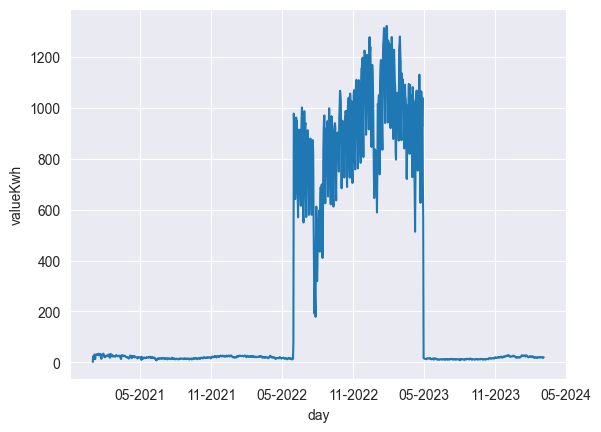

In [154]:
kwhUsage = pd.read_sql_query("SELECT (SUM(valueKwh) / MAX(anzMeter)) as valueKwh, plz,STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter where plz=6280 GROUP BY day;", connection)
kwhUsage['day'] = pd.to_datetime(kwhUsage['day'])
plot = sns.lineplot(data=kwhUsage, x='day', y='valueKwh')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Ein Bereinigen der Daten durch das Vertrauensintervall verändert die Daten nur minimal, da der Zeitraum mit den potenziell zu hohen Messungen im Vergleich zum gesamten Zeitraum zu lang ist. Es wird daher als sinnvoller erachtet, die Daten von Hochdorf bei einer entsprechenden Auswertung komplett auszublenden. Da bei diesem langen Zeitraum an fehlenden Daten ein Ersetzen durch Schätzungen sehr ungenau wäre. Daher kann für Hochdorf keine verlässliche Auswertung vorgenommen werden.

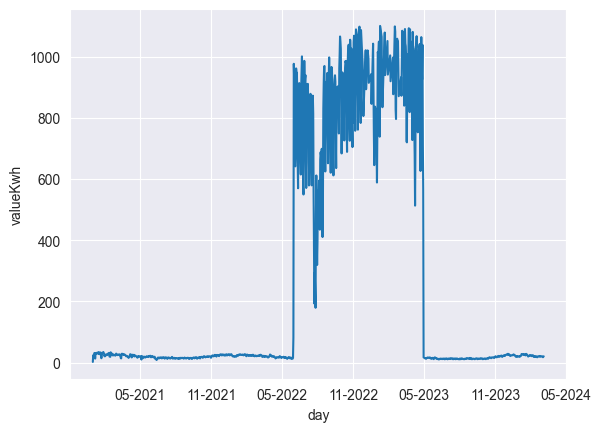

In [155]:
# Statistische Masse berechnen
mean = kwhUsage['valueKwh'].mean()
std = kwhUsage['valueKwh'].std()

# Vertrauensintervall berechnen (z.B. für 95% Konfidenzniveau)
confidence_level = 0.95
z_score = 1.96  # Z-Wert für 95% Konfidenzniveau

# Grenzen des Vertrauensintervalls
lower_bound = mean - z_score * std
upper_bound = mean + z_score * std

# Daten filtern, um nur die Werte innerhalb des Vertrauensintervalls zu behalten
filtered_kwhUsage = kwhUsage[(kwhUsage['valueKwh'] >= lower_bound) & (kwhUsage['valueKwh'] <= upper_bound)]

plot = sns.lineplot(data=filtered_kwhUsage, x='day', y='valueKwh')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Auch durch eine fehlerhafte Anzahl Smartmeter lässt sich die Abweichung nicht erklären.

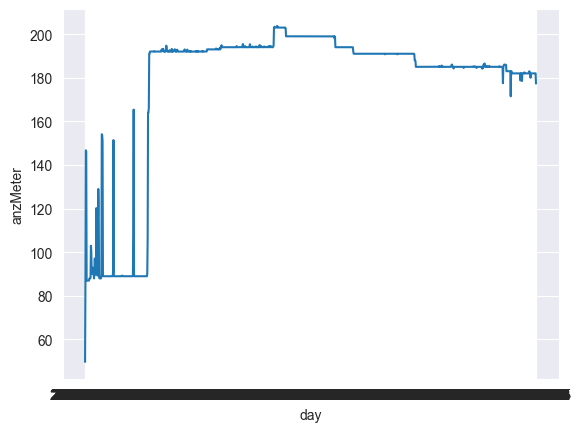

In [156]:
anzSmartmeter = pd.read_sql_query("SELECT AVG(anzMeter) as anzMeter, plz, STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter where plz=6280 GROUP BY day;", connection)
plot = sns.lineplot(data=anzSmartmeter, x='day', y='anzMeter')

plt.show()

Durch die fehlerhaften Daten bei Hochdorf liegt der Verdacht nahe, dass auch andere Ortschaften ähnliche Phänomene aufweisen. Dazu wird nachfolgend ein entsprechender Datensatz gezogen und mittels Pivot umgeformt. Das Ergebnis sind die Zeitreihen der PLZ pro Spalte.

In [157]:
kwhUsage = pd.read_sql_query("SELECT (SUM(valueKwh) / MAX(anzMeter)) as valueKwh, plz, STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter GROUP BY day, plz ORDER BY day DESC;", connection)
kwhUsagePivot = kwhUsage.pivot(index='day', columns='plz', values='valueKwh')
kwhUsagePivot.head()

plz,4806,4915,5735,6005,6010,6014,6015,6016,6017,6018,...,6283,6284,6285,6286,6287,6288,6289,6294,6295,6344
day,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.774625,NaN,0.169696,0.876658,0.455765,1.496481,0.510227,1.701463,1.274624,1.228038,...,1.193634,1.697221,1.806750,NaN,1.140796,1.954758,1.408436,1.057834,NaN,1.277902
2021-01-01,25.955519,NaN,16.569408,19.412543,10.708739,19.513581,11.766039,21.075182,17.264149,21.595272,...,16.213054,25.532267,23.500740,NaN,24.136652,41.533324,21.886049,19.749613,NaN,27.968808
2021-01-02,26.537000,NaN,16.393148,20.653018,11.120173,20.476257,13.537091,20.322217,18.513564,21.813985,...,8.900955,27.066261,23.485556,NaN,26.081453,42.285853,23.748175,21.366213,NaN,29.015273
2021-01-03,26.429444,NaN,17.275533,21.074482,11.153531,20.311903,12.864176,21.444496,18.483932,22.703215,...,9.318940,27.489276,23.872744,NaN,26.549974,41.932235,23.368400,22.346163,NaN,38.732415
2021-01-04,29.880750,NaN,23.049183,22.208211,14.533510,33.385679,15.084881,21.222290,20.279953,27.243326,...,17.252239,29.418337,25.114635,NaN,33.972470,40.387697,29.008527,25.457551,NaN,46.694131


Für eine visuelle Überprüfung der Daten werden nachfolgend alle Zeitreihen grafisch dargestellt. Dabei fällt auf, dass einzelne Ortschaften Peaks aufweisen, oder teilweise auch andere, unglaubhafte Daten zeigen, welche von den anderen abweichen. Eine Glättung der Daten wurde aber nicht als sinnvoll erachtet, da einige Ausprägungen durchaus plausibel sein können und durch eine Glättung verfälscht würden. 

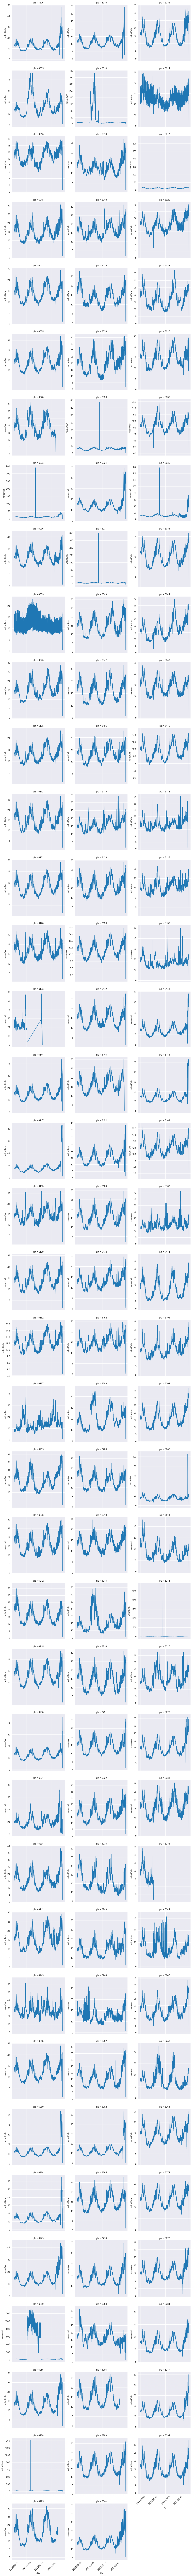

In [151]:
# FacetGrid erstellen
g = sns.FacetGrid(kwhUsage, col='plz', col_wrap=3, height=4, sharex=True, sharey=False)
g.map(sns.lineplot, 'day', 'valueKwh')

# Achsenbeschriftungen und Titel hinzufügen
for ax in g.axes.flat:
    ax.set_xlabel('day')
    ax.set_ylabel('valueKwh')
    
    # Intervall der x-Achsenbeschriftungen anpassen
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  

    # Rotation der Beschriftungen
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.show()

In [ ]:
#Test Date Time and manipulation

#input = '202001240000'
#output = '%Y%m%d%H%M'

#date = input.strftime('%Y-%m-%d %H:%M')
#date = datetime.datetime.strptime('202001240000', '%Y%m%d%H%M').strftime('%Y-%m-%d %H:%M')

#df = pd.DataFrame({'date':['2020012400', '2020012400']})

#print(df)

#df['date'] += '00'

#print(df)

### Historische Meteo Daten
**Herausgeber:**
Eidgenössisches Departement des Innern (EDI)
Bundesamt für Meteorologie und Klimatologie MeteoSchweiz
Wird zitiert als MeteoSchweiz [Zitierwunsch](https://gate.meteoswiss.ch/idaweb/more.do)

**Link:**
https://gate.meteoswiss.ch/idaweb/more.do

**Beschreibung:**
Die historischen Meteodaten bestehen aus Archivdaten des Bodenmessnetzes von MeteoSchweiz. MeteoSchweiz liefert Messgrössen wie z.B. Niederschlag, Temperatur oder Sonnenstunden. Diese Informationen können Interessant sein, um festzustellen ob diese einen Effekt auf den Stromverbrauch haben. Die Daten können in Zehnminutenwerte, Stundenwerte, Tageswerte, Monatswerte oder Jahreswerte geladen werden. Die Daten können über das Web-Portal IDAWEB zusammengestellt und heruntergeladen werden. (MeteoSchweiz, [Online-Quelle](https://gate.meteoswiss.ch/idaweb/more.do)).

**Zeitraum:**
Es stehen alle Meteodaten seit Messbeginn zu Verfügung. Die Smartmeterdaten stehen für den Zeitraum vom 2020-12-30 00:00 - 2024-03-06 23:00 zu Verfügung. Aus diesem Grund wird für die Meteodaten derselbe Zeitraum gewählt.

**Zweckerfüllung:**
Mit den Meteodaten sollen gewisse Abhängigkeiten festgestellt werden. So wird z.B. erwartet, dass mit zunehmenden Sonnenstunden, der Strombedarf sinkt aufgrund der zahlreichen privaten Solaranlagen. Durch den Niederschlag soll festgestellt werden, ob dieser den Strombedarf positiv oder negativ beeinflusst auch in Kombination mit der Temperatur. Hat der Niederschlag einen merkbaren Einfluss, wenn in einem vergleichbaren Zeitraum die Temperatur gleich bleibt.
Diese drei Parameter werden auf stündlicher Basis für den gewählten Zeitraum geladen.  Folgende Parameter werden erhoben:
- Niederschlag, Stundensumme in Millimeter
- Lufttemperatur 2m über Boden, Stundenmittel in Grad Celsius
- Sonnenscheindauer, Stundensumme in Minuten

Im Grundsatz werden die Anforderungen damit erfüllt.

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* Die Glaubwürdigkeit ist gegeben, da es sich um die offizielle Meteo Stationen des Bundes handelt. Neben den Daten des Bundes stand die Quelle [Open-Meteo.com](https://open-meteo.com/en/docs/historical-weather-api) als API zur Auswahl. Auf diese wurde verzichtet. Dies aus den Gründen, dass die historischen Daten basierend auf Wetterstationen, Flugzeugen, Boyen, Radar und Satelliten Beobachtungen berechnet werden und nicht klar ist, wie genau diese Daten sind. Eine weitere Unsicherheit ist, dass die verwendeten Datasets auf Mittel- bis Langvorhersagen ausgerichtet sind sowie einen globalen Fokus haben [Open-Meteo.com](https://open-meteo.com/en/docs/historical-weather-api). Da im Projektteam die meteorologische Expertise fehlt zur Verifizierung wie gut diese Daten sind, werden die Daten von MeteoSchweiz verwendet.

*Nützlichkeit:* Das IDAWEB Portal von MeteoSchweiz stellt die Messdaten von Messstationen zu Verfügung. Damit entsteht die Schwierigkeit, dass nicht pro BFS-ID oder PLZ direkt die gewünschten Messdaten zu Verfügung stehen. Während des Abfrageprozesses, müssen zuerst die potenziellen Messstationen ausgewählt werden. Danach folgen die gewünschten Messparameter sowie der Zeitraum. Daraus ergibt sich ein Set an Messdaten welches zu Verfügung steht. Beim Niederschlag steht eine gute Menge an Messtationen zu Verfügung, welche den Kanton Luzern gut abdecken. Im Bereich der Sonnenstunden und Temperatur ist dies jedoch nicht der Fall. Bei den Sonnenstunden gibt es generell kaum Messstationen. Bei der Temperatur gibt es verschiedene Messhöhen z.B. direkt am Boden, 5cm ab Boden oder 2m ab Boden. Teilweise wird auch keine Höhe angegeben. Die Messtationen mit einer Messhöhe von 2m erfüllen den internationalen Standard und sind dabei nicht der Witterung oder Sonnenstrahlung ausgesetzt, welche die Messwerte verfälschen würden (MeteoSchweiz, [Online-Quelle](https://www.meteoschweiz.admin.ch/wetter/wetter-und-klima-von-a-bis-z/temperatur.html)). 
Die geografische Abdeckung der Temperatur Messtationen mit 2m Höhe ist nicht flächendeckend. Bei den Temperatur Messstationen ohne Höhen Angabe, gibt es eine breitere Abdeckung jedoch mit der Ungewissheit, wie die Temperaturen gemessen werden. Je nach Position können grössere Schwankungen auftreten. Aus diesem Grund werden die Meteostationen gewählt, welche die Temperatur 2 Meter über dem Boden messen. Damit ist eine einheitliche Messmethodik gewährleistet und die Vergleichbarkeit gegeben. Damit die Daten nutzbar eingesetzt werden können, wird aufgrund der geografischen Position der Messstation die BFS-ID zugeordnet. Dies erfolgt manuell in einer gesonderten CSV-Datei. Die geografische Verteilung und Zuordnung folgt in der Analyse.

*Interpretierbarkeit:* Nachdem die gewünschten Parameter gewählt wurden, werden die Messdaten exportiert. Es wird pro Messstation und Parameter eine TXT-Datei mit einer Legende erstellt und eine mit den Messdaten. Insgesamt sind dies 370 TXT-Dateien. In der Legende werden jeweils die Meteostation beschrieben mit der Bezeichnung, Parameter, Koordinate und ID. Zusätzlich gibt es ein Beschreibung zum Parameter. Aufgrund des TXT-Formats und keinen Trennzeichen wurden die Meteostationen manuell in der Datei meteoStation.csv erfasst. Dasselbe gilt für die drei Parameter. Die wurden manuell in die Datei parameter.csv geschrieben. Die Messstationen verfügen über keine PLZ oder BFS-ID, daher werden diese Informationen manuell in der CSV-Datei ergänzt.
Die Messdaten TXT-Datei beinhaltet die Station-ID, Zeitstempel sowie den Wert, des Parameters. Die Bezeichnung des Parameters steht in der Spaltenbezeichnung. Es besteht viel manueller Aufwand und die Maschinen lesbarkeit ist nur bei den Messdaten TXT-Dateien gegeben. Daher ist die Interpretierbarkeit für den hier benötigten Kontext nur mit manuellem Aufwand gegeben. Zur Sicherung in der Datenbank, müssen die Daten angereichert werden damit die Daten später wieder korrekt zusammengesetzt werden können.

*Schlüsselintegrität:* Die Messdaten TXT-Dateien haben aber keinen Primary Key, besitzen aber die Foreign-Key's der Messstationen-ID sowie der Parameter-ID. Damit lassen sich die Messdaten wieder zusammensetzen. Damit pro BFS-ID alle drei Parameter geladen werden können, wird eine Mapping-Tabelle benötigt welche jeweils die BFS-ID jeweils mit dem gewünschten Parameter der geografisch nächsten Meteostation verbindet.

**Verfügbarkeit:** Die Daten stehen für Forschungs- und Lehrzwecke allen zu Verfügung. Es ist ein Registrierungsprozess notwendig, um Zugriff auf die Daten zu erhalten.

**Preis:** Im Kontext von Forschungs- und Lehrzwecken können die Daten kostenlos genutzt werden. Eine kommerzielle Nutzung ist untersagt. Die Verwendung der Daten für Grafiken, Text oder Vorträge ist erlaubt mit entsprechender Kennzeichnung der Quelle mit MeteoSchweiz. (MeteoSchweiz, [Online-Quelle](https://gate.meteoswiss.ch/idaweb/more.do))

#### Inhaltliche Analyse und Schwierigkeiten 
Die manuell aufbereitete CSV Datei "parameter" beinhaltet drei Einträge und drei Spalten. -
- **parameterID**, gibt den gemessenen Wert an
- **measure**, Masseinheit der Messung
- **description**, Was wird gemessen und in welchem Zeitintervall

In [ ]:
#Import Meteo Parameter
meteoParameter = pd.read_csv("./DATA/meteo/parameter.csv", delimiter=";")
meteoParameter.info()
meteoParameter.head()

Nachfolgend wird die Datei in die Datenbank gelesen.

In [ ]:
meteoParameter["parameterID"] = '"' + meteoParameter["parameterID"] + '"'
meteoParameter["measure"] = '"' + meteoParameter["measure"] + '"'
meteoParameter["description"] = '"' + meteoParameter["description"] + '"'
for index, row in meteoParameter.iterrows():
    sql = "INSERT INTO meteoParameter VALUES({}, {}, {})".format(row["parameterID"], row["measure"], row["description"])
    cursor.execute(sql)

connection.commit()

Diese CSV-Datei meteoStation.csv wurde manuell erstellt. Dazu mussten die jeweiligen Legenden-Einträge von jedem Daten-Export einzeln kopiert werden und in die CSV-Datei integriert werden. Jede Station verfügt über einen expliziten Namen sowie Betreiber/Herausgeber der Messdaten. Damit bekannt ist wo sich die Meteostationen befinden, werden die Koordinaten mitgegeben. Die Koordinaten sind in einem internationalen Format angegeben auch bekannt als WGS84, welches für das GPS verwendet wird. Zusätzlich sind die Koordinaten im Schweizer LV03 Format vorhanden. Für die weitere Verarbeitung und Verknüpfung der Daten muss nun die BFS-ID sowie der Gemeindenamen manuell hinzugefügt werden. Dazu wurde die Online Karte von Swisstopo (https://map.geo.admin.ch/) verwendet mit den entsprechend eingeblendeten Gemeindegrenzen. Dadurch konnte visuell erkannt werden, welche Meteostation zu welcher Gemeinde gehört.
- **stn**, Messstation-ID
- **stnName**, Messstationen Name
- **lawCityName**, Gemeindename zu der entsprechenden BFS-Nummer
- **datasource**, Betreiber/Herausgeber der Messstation
- **bfsId**, BFS-Nummer der Gemeinde wo sich die Messstation befindet
- **coEast** & **coNorth**, Schweizer Koordinaten-Format LV03
- **coLength** & **coWide**, internationales Koordinaten Format WGS84

In [ ]:
meteoStations = pd.read_csv("./DATA/meteo/meteoStation.csv", delimiter=";")
meteoStations.info()
meteoStations.head()

Während der Selektion der Daten wurde die Problematik der nicht flächendeckenden Abdeckung erkannt. Insgesamt stehen 75 Messstationen zu Verfügung. Mit dem Import wird klar, dass zu 50 Gemeinden eine eindeutige Messtation zugeteilt werden konnte. Somit besteht ein Delta von 30 Gemeinden, die keine direkte Messstation haben. Was auch klar wird, ist dass manchen Gemeinden über mehrere Stationen verfügen. Emmen verfügt als Spitzenreiter über fünf Messstationen. Die verfügbaren Messungen an diesen Stationen wurde bisher noch nicht berücksichtigt. 

In [ ]:
print('Anzahl Messstationen: ', meteoStations['stn'].nunique())
print('Anzahl eindeutige BFS-ID: ', meteoStations['bfsId'].nunique())
cityLu_df = city_df.query("Kantonskürzel == 'LU'")
print("Anz. Eindeutige BFS-Nr im Kanton Luzern:", cityLu_df['BFS-Nr'].nunique())
meteoStations[["lawCityName", "stn"]].groupby('lawCityName').count().sort_values(by=['stn'], ascending=False)

Nachfolgend werden die Daten in die Datenbank eingelesen.

In [ ]:
meteoStations["stn"] = '"' + meteoStations["stn"] + '"'
meteoStations["stnName"] = '"' + meteoStations["stnName"] + '"'
meteoStations["lawCityName"] = '"' + meteoStations["lawCityName"] + '"'
meteoStations["datasource"] = '"' + meteoStations["datasource"] + '"'
meteoStations["coLength"] = '"' + meteoStations["coLength"] + '"'
meteoStations["coWide"] = '"' + meteoStations["coWide"] + '"'

for index, row in meteoStations.iterrows():
    sql = "INSERT INTO meteoStations VALUES({}, {}, {}, {}, {}, {}, {}, {}, {})".format(row["stn"], row["stnName"], row["lawCityName"], row["datasource"], row["bfsId"], row["coEast"], row["coNorth"], row["coLength"], row["coWide"])
    cursor.execute(sql)

connection.commit()

Nun werden die Messdaten eingelesen. Diese geschieht pro Parameter. Alle Messungen setzen sich aus der Messstation (stn), dem Zeitstempel (time) und dem Wert (parameterName z.B. rre150h0) zusammen. Gestartet wird mit den Regendaten. Das sind 1,95 Millionen Messungen. Davon sind 60605 NA Werte und die Niederschlagsdaten sind über 71 Messstationen verfügbar. Das entspricht einer guten Abdeckung. Die NA Werte werden nun weiter untersucht.
- **stn**, Messtation
- **time**, Zeitstempel im Format YYYYMMDDHH
- **rre150h0**, Summierter Niederschlag in mm pro Stunde

In [ ]:
#Import MeteoData of parameter rre150h0
#Files bereinigen mit den ersten zwei Zeilen jeder Datei überspringen
#Datum umformatieren damit SQLite dies interpretieren kann
path = './DATA/meteo/data'
csv_files = glob.glob(path + '/*rre150h0*data.txt')
df_list = (pd.read_csv(file, delimiter=';', na_values= '-') for file in csv_files)

meteo_df = pd.concat(df_list, ignore_index=True)

meteo_df.info()
print("\nAnzahl leere Werte:\n", meteo_df.count())

print("\nAnzahl eindeutige Messstationen: ", meteo_df['stn'].nunique())
meteo_df.head()



Wie aus der Analyse entnommen werden kann, liefern von 71 Stationen nur 5 vollständige Daten. 66 Stationen haben lücken in ihren Daten. Da es sich hier um die Niederschlagsmenge in der Stundensumme handelt, sind 4707 fehlende Stundenangaben signifikant. Das entspricht umgerechnet ca. 196 Tage fehlende Daten. Dies muss in der Phase der Analyse berücksichtigt werden und stellt eine Schwierigkeit dar. 

In [ ]:
meteoNA_df = meteo_df[meteo_df['rre150h0'].isna()]
meteoNA_df[['rre150h0']].isna().groupby(meteoNA_df['stn']).sum().sort_values(by=['rre150h0'], ascending=False)


In [ ]:

#df = meteo_df[meteo_df['stn'] == 'ZELUTB'].copy()
#df.sort_values(by='time')
#df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
#df.dropna(inplace=True)
#dfNA = df[df['rre150h0'].isna()].copy()
#dfNA.info()
#df.drop(columns='stn', inplace=True)
#df['rre150h0' == 'NaN'] = np.nan
#df.replace(np.nan, -20, inplace=True)
#plt.plot(df.time, df.rre150h0, linewidth=2.0)
#dfNA.replace(np.nan, 0, inplace=True)
#df.drop_duplicates(inplace=True)
#plt.plot(dfNA.time, dfNA.rre150h0, color='red', linewidth=1)



#meteoNAplot = sns.lineplot(data=df, x='time', y='rre150h0', color= 'red')
#meteoNAplot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
#meteoNAplot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.show()
#df.info()
#meteoNA_df.head()


Der verfügbare Zeitraum wurde auf dem IDAWEB Portal angegeben. Um sicherzustellen, dass auch die vollständigen Daten vorhanden sind, wird pro Station überprüft, für welche Zeiträume die Daten zu Verfügung stehen. Es wird ersichtlich, dass die Messtationen ZELULB, ZELUHB, ZELUWI und ZELUUM die Daten nur bis Mitte bzw. Ende Januar liefern. Dies muss in der Analyse entsprechend berücksichtigt werden.

In [ ]:
stnNames = meteo_df['stn'].unique().tolist()
df_dict = {stn: meteo_df[meteo_df['stn'] == stn] for stn in stnNames}
d = {'stn': [], 'minDate': [], 'maxDate': [], 'nanValues': []}
df = pd.DataFrame(data=d)

for key in df_dict:
    tmp_df = pd.DataFrame.from_dict(df_dict[key])
    tmp_df['time'] = pd.to_datetime(tmp_df['time'], format='%Y%m%d%H')
    minDate = tmp_df['time'].min()
    maxDate = tmp_df['time'].max()
    nanValues = tmp_df['rre150h0'].isna().sum()
    df.loc[len(df.index)] = [key, minDate, maxDate, nanValues]

df.sort_values(by='maxDate', ascending=True, inplace=True)
df.head(80)

Die Daten werden nun importiert. Dazu müssen die NaN Werte mit NULL ersetzt werden und der Zeitstempel in einem für SQLite lesbaren Zeitformat gesichert werden.

In [ ]:
meteo_df.replace(np.nan, "NULL", inplace=True)
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df['time'] = pd.to_datetime(meteo_df.time)
meteo_df['time'] = meteo_df['time'].dt.strftime('%Y-%m-%d %H:%M')

meteo_df['time'] = '"' + meteo_df['time'] + '"'
meteo_df['stn'] = '"' + meteo_df['stn'] + '"'


for index, row in meteo_df.iterrows():
    sql = "INSERT INTO meteoData VALUES(NULL,{},{},{},{})".format(row["stn"], '"rre150h0"', row["time"], row["rre150h0"])
    cursor.execute(sql)

connection.commit()

Der die nächsten Messdaten sind die Temperaturen. Insgesamt sind es 334944 Messungen wovon 2222 NA Werte sind. Die Messungen wurden mit 12 Messtationen erstellt. Im Vergleich zu den Niederschlag-Messstationen sind dies 59 Stationen weniger. Wie bereits erwähnt ist die Abdeckung der Temperatur-Messstationen nicht sehr hoch.
- **stn**, Messtation
- **time**, Zeitstempel im Format YYYYMMDDHH
- **tre000h0**, Durchschnittliche Temperatur pro Stunde in Grad Celsius

In [ ]:
#Import MeteoData of parameter tre200h0
path = './DATA/meteo/data'
csv_files = glob.glob(path + '/*tre200h0*data.txt')
df_list = (pd.read_csv(file, delimiter=';', na_values= '-') for file in csv_files)
meteo_df = pd.concat(df_list, ignore_index=True)
meteo_df.info()
print("\nAnzahl leere Werte:\n", meteo_df.count())

print("\nAnzahl eindeutige Messstationen: ", meteo_df['stn'].nunique())
meteo_df.head()

Die NA Werte teilen sich auf 8 Stationen auf. Die meisten NA Werte hat die Station INNRED mit 1056 fehlenden Stundendaten was 44 Tagen entspricht. In der Analyse muss weiter untersucht werden, wie die Daten dieser Station verwendet werden können. Die restlichen Stationen weisen geringe fehlende Daten auf und können daher gut verwendet werden.

In [ ]:
meteoNA_df = meteo_df[meteo_df['tre200h0'].isna()]
meteoNA_df[['tre200h0']].isna().groupby(meteoNA_df['stn']).sum().sort_values(by=['tre200h0'], ascending=False)

Der verfügbare Zeitraum wurde auf dem IDAWEB Portal angegeben. Um sicherzustellen, dass die vollständigen Daten vorhanden sind, wird pro Station überprüft, für welche Zeiträume die Daten zu Verfügung stehen. Es wird ersichtlich, dass die Messtationen vollumfänglich für jede Station zu Verfügung stehen.

In [ ]:
stnNames = meteo_df['stn'].unique().tolist()
df_dict = {stn: meteo_df[meteo_df['stn'] == stn] for stn in stnNames}
d = {'stn': [], 'minDate': [], 'maxDate': [], 'nanValues': []}
df = pd.DataFrame(data=d)

for key in df_dict:
    tmp_df = pd.DataFrame.from_dict(df_dict[key])
    tmp_df['time'] = pd.to_datetime(tmp_df['time'], format='%Y%m%d%H')
    minDate = tmp_df['time'].min()
    maxDate = tmp_df['time'].max()
    nanValues = tmp_df['tre200h0'].isna().sum()
    df.loc[len(df.index)] = [key, minDate, maxDate, nanValues]

df.sort_values(by='maxDate', ascending=True, inplace=True)
df.head(80)

Die Daten werden nun importiert. Dazu müssen die NaN Werte mit NULL ersetzt werden und der Zeitstempel in einem für SQLite lesbaren Zeitformat gesichert werden.

In [ ]:
meteo_df.replace(np.nan, "NULL", inplace=True)
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df['time'] = pd.to_datetime(meteo_df.time)
meteo_df['time'] = meteo_df['time'].dt.strftime('%Y-%m-%d %H:%M')

meteo_df['time'] = '"' + meteo_df['time'] + '"'
meteo_df['stn'] = '"' + meteo_df['stn'] + '"'

for index, row in meteo_df.iterrows():
    sql = "INSERT INTO meteoData VALUES(NULL,{},{},{},{})".format(row["stn"], '"tre200h0"', row["time"], row["tre200h0"])
    cursor.execute(sql)

connection.commit()

Als letzter Parameter werden die Sonnenstunden eingelesen. Mit 99646 Messungen und 4 Messstationen stehen zu dieser Messung die wenigsten Daten zu Verfügung. Dafür fehlen lediglich 112 Werte. Allgemein ist die Abeckung sehr dünn.
- **stn**, Messtation
- **time**, Zeitstempel im Format YYYYMMDDHH
- **sre000h0**, Dauer des Sonnenscheins pro Stunde in Minuten

In [ ]:
#Import MeteoData of parameter sre000h0
path = './DATA/meteo/data'
csv_files = glob.glob(path + '/*sre000h0*data.txt')
df_list = (pd.read_csv(file, delimiter=';', na_values= '-') for file in csv_files)

meteo_df = pd.concat(df_list, ignore_index=True)

meteo_df.info()
print("\nAnzahl leere Werte:\n", meteo_df.count())

print("\nAnzahl eindeutige Messstationen: ", meteo_df['stn'].nunique())
meteo_df.head()

Wenn die Messstationen näher betrachtet werden, weisst LUZ 111 fehlende Werte auf was nur 4.6 Tagen entspricht. Daher können diese Daten gut verwendet werden. 

In [ ]:
meteoNA_df = meteo_df[meteo_df['sre000h0'].isna()]
meteoNA_df[['sre000h0']].isna().groupby(meteoNA_df['stn']).sum().sort_values(by=['sre000h0'], ascending=False)

Der verfügbare Zeitraum wurde auf dem IDAWEB Portal angegeben. Um sicherzustellen, dass auch die vollständigen Daten vorhanden sind, wird pro Station überprüft, für welche Zeiträume die Daten zu Verfügung stehen. Es wird ersichtlich, dass die Messtationen SPF und EGO die Daten nur bis Ende Juni 2023 liefern. Dies muss in der weiteren Analyse entsprechend berücksichtigt werden.

In [ ]:
stnNames = meteo_df['stn'].unique().tolist()
df_dict = {stn: meteo_df[meteo_df['stn'] == stn] for stn in stnNames}
d = {'stn': [], 'minDate': [], 'maxDate': [], 'nanValues': []}
df = pd.DataFrame(data=d)

for key in df_dict:
    tmp_df = pd.DataFrame.from_dict(df_dict[key])
    tmp_df['time'] = pd.to_datetime(tmp_df['time'], format='%Y%m%d%H')
    minDate = tmp_df['time'].min()
    maxDate = tmp_df['time'].max()
    nanValues = tmp_df['sre000h0'].isna().sum()
    df.loc[len(df.index)] = [key, minDate, maxDate, nanValues]

df.sort_values(by='maxDate', ascending=True, inplace=True)
df.head(80)

Die Daten werden nun importiert. Dazu müssen die NaN Werte mit NULL ersetzt werden und der Zeitstempel in einem für SQLite lesbaren Zeitformat gesichert werden.

In [ ]:
meteo_df.replace(np.nan, "NULL", inplace=True)
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df['time'] = pd.to_datetime(meteo_df.time)
meteo_df['time'] = meteo_df['time'].dt.strftime('%Y-%m-%d %H:%M')

meteo_df['time'] = '"' + meteo_df['time'] + '"'
meteo_df['stn'] = '"' + meteo_df['stn'] + '"'

for index, row in meteo_df.iterrows():
    sql = "INSERT INTO meteoData VALUES(NULL,{},{},{},{})".format(row["stn"], '"sre000h0"', row["time"], row["sre000h0"])
    cursor.execute(sql)

connection.commit()

Bisher wurden sämtliche Daten ohne Zugehörigkeit zu einer Gemeinde importiert. Jetzt fehlt eine Zuordnung eines Meteoparameters inkl. zugehörigier Messstation zu einer Gemeinde. Besonders für solche welche über keine eigene Messtation verfügen. Dieses Mapping wird manuell durchgeführt. Unterstützend wird eine Karte generiert, auf welcher sämtliche Messstationen aufgeführt sind. Die Koordinaten der Messstationen müssen jeweils umgerechnet werden von LV03 auf WGS84. Dazu liefert Swisstopo auf Github ein entsprechendes Skript (Swisstopo, [Online-Quelle](https://github.com/ValentinMinder/Swisstopo-WGS84-LV03/tree/master)). Für die Umrechnung wird die Funktion CHtoWGSlat verwendet.

In [ ]:
#Script for translating Swiss coordinates LV03 to Global coordinates WGS84
#Sources: Swisstopo, https://github.com/ValentinMinder/Swisstopo-WGS84-LV03/tree/master

class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
              - (0.270978 * pow(y_aux, 2)) + \
              - (0.002528 * pow(x_aux, 2)) + \
              - (0.0447 * pow(y_aux, 2) * x_aux) + \
              - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
               + (0.791484 * y_aux * x_aux) + \
               + (0.1306 * y_aux * pow(x_aux, 2))) + \
              - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)

    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)

    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
              + (3745.25 * pow(lng_aux, 2)) + \
              + (76.63 * pow(lat_aux,2))) + \
             - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

    # Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d

    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d

Die Meteostationen werden nun aus der DB geladen. Anschliessend werden die coEast und coNorth umgerechnet und in je einer Spalte ergänzt.

In [ ]:
#Load List of meteoStations
meteostation_df = pd.read_sql_query("SELECT meteoStationsParameter.bfsID, meteoStation, meteoParameter, stn, stnName, lawCityName, coEast, coNorth FROM meteoStationsParameter LEFT JOIN meteoStations ON meteoStation = stn", connection)

meteostation_df['lat'] = GPSConverter.CHtoWGSlat('',meteostation_df['coEast'], meteostation_df['coNorth'])
meteostation_df['long'] = GPSConverter.CHtoWGSlng('',meteostation_df['coEast'], meteostation_df['coNorth'])

meteostation_df.rename(columns={'bfsID':'bfs_ID'})
meteostation_df.head(1000)

Nun wird die Basis-Map geladen. In dieser sind die Luzerner Gemeindegrenzen dargestellt.

In [ ]:
#Basic Map with Gemeinden
map_df = raw_geodf[raw_geodf['kanton.KUERZEL'] == 'LU']

fig = px.choropleth_mapbox(
    map_df,
    geojson=map_df.geometry,
    locations=map_df.index,                                 # define feature variable
    color_continuous_scale=px.colors.diverging.Geyser,           # define color palette
    labels={'gemeinde.NAME':'Gemeinde Kanton Luzern'},
    hover_name='gemeinde.NAME',                                       # define mouse over infos
    hover_data={'gemeinde.BFS_NUMMER':True},
    opacity=0.5,
    center=map_center,
    zoom=map_zoom,
    mapbox_style="carto-positron"                                # other option "open-street-map"
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.show()


Im zweiten Schritt werden nun die Messtationen für die Temperatur geladen. Was sich bereits bei der ersten Sichtung angedeutet hatte, wird nun auf der Karte deutlich. In der Mitte des Kanton Luzern besteht eine grössere Lücke. Dafür gibt es eine hohe Dichte im Bereich von Emmen und Luzern. Die Messtation INNRED, welche eine hohe Anzahl an fehlenden Daten aufweist, könnte ignoriert werden, da in der Nähe zwei weitere Stationen zu Verfügung stehen. Das ausschlaggebende Kriterium wird sein, ob grössere Zeiträume fehlen oder nur einzelne Datenpunkte. Anhand dieser Grafik werden nun die Messtationen mit dem Parameter der Temperatur einer BFS-ID zugewiesen.

In [ ]:
meteoStationsTemp_df = meteostation_df[meteostation_df['meteoParameter'] == 'tre200h0']
fig.add_scattermapbox(
    #geojson=joined_geodf_meteoStn.geometry,
    #locations=joined_geodf_meteoStn.index,
    customdata=meteoStationsTemp_df,
    lat=meteoStationsTemp_df['lat'],
    lon=meteoStationsTemp_df['long'],
    hovertext='Stationsname: ' + meteoStationsTemp_df['meteoStation'],
    legendgroup='l1',
    name='Messstationen Temperatur',
    marker=dict(color='firebrick')
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

fig.show()

Die Messtationen für den Regen sind sehr gut verteilt im Kanton Luzern und können daher gut verwendet werden. Aufgrund der z.T. mehrfachen Abdeckung können Messtationen mit vielen fehlenden Daten bereits jetzt ausgeschlossen werden. evtl. können Daten ergänzt werden.
ZELUZI mit 1579 --> SPF (Schüpfheim)
ZELULI mit 997 --> LUZ (Luzern)
LUMAL mit 749 --> ZELUUM (Malters)
ZELULB mit 524 --> ZELUUM (Malters)
ZELUHE mit 554 --> NABBRM (Beromünster)
ZELUTG mit 1888 --> ZELUNK (Neuenkirch)
ZELUTR mit 764 --> MMTRG (Triengen)
ZELUBU mit 3435 --> ZELUST (Dagmersellen)
ZELUMB mit 848 --> ZELUME (Menznau)
ZELUGE mit 413 --> LUWIL (Willisau)

--> Mit einem Klick auf den Legendeneintrag, können die verschiedenen Messstationen ausgeblendet werden.


In [ ]:
meteoStationsTemp_df = meteostation_df[meteostation_df['meteoParameter'] == 'rre150h0']
fig.add_scattermapbox(
    #geojson=joined_geodf_meteoStn.geometry,
    #locations=joined_geodf_meteoStn.index,
    customdata=meteoStationsTemp_df,
    lat=meteoStationsTemp_df['lat'],
    lon=meteoStationsTemp_df['long'],
    hovertext='Stationsname: ' + meteoStationsTemp_df['meteoStation'],
    legendgroup='l2',
    name='Messstationen Niederschlag',
    marker=dict(color='navy')
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

fig.show()

Mit der Kartenansicht wird sofort klar, dass die Abdeckung mit den Sonnenstunden nicht sehr gross ist. Die Stationen sind geografisch zwar schön verteilt in den jeweiligen Viertel des Kantons. Wie bei der ersten Daten-Analyse klar wurde verfügen die Standorte SPF und EGO nur Daten bis zum 30.6.2023 somit fällt die westliche Hälfte für diesen Zeitraum weg. Dies muss in der weiteren Analyse berücksichtigt werden. Die Stationen werden anhand der geografischen Nähe zu den Gemeinden manuell zugeteilt.

In [ ]:
meteoStationsTemp_df = meteostation_df[meteostation_df['meteoParameter'] == 'sre000h0']
fig.add_scattermapbox(
    #geojson=joined_geodf_meteoStn.geometry,
    #locations=joined_geodf_meteoStn.index,
    customdata=meteoStationsTemp_df,
    lat=meteoStationsTemp_df['lat'],
    lon=meteoStationsTemp_df['long'],
    hovertext='Stationsname: ' + meteoStationsTemp_df['meteoStation'],
    legendgroup='l3',
    name='Messstationen Sonnenstunden',
    marker=dict(color='yellow')
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

fig.show()

Die manuell erstellte Liste meteoStationsBfsParameter wird nun eingelesen. Sie verfügt über die Spalten bfsID welche die BFS-Nummer der Gemeinde darstellt. In der Spalte meteoParameter wird der gemessene Meteoparameter angegeben und mit meteoStation die dazugehörige Meteo Station.
- **bfsID**, BFS-Nummer
- **meteoParameter**, gemessener Parameter
- **meteoStation**, zugehörige Messstation

In [ ]:
#Import MeteoParamBFS
meteoParams = pd.read_csv("./DATA/meteo/meteoStationBfsParameter.csv", delimiter=";")

meteoParams.info()

meteoParams["meteoParameter"] = '"' + meteoParams["meteoParameter"] + '"'
meteoParams["meteoStation"] = '"' + meteoParams["meteoStation"] + '"'

for index, row in meteoParams.iterrows():
    sql = "INSERT INTO meteoParamBfs VALUES(NULL, {}, {}, {})".format(row["bfsID"], row["meteoParameter"], row["meteoStation"])
    cursor.execute(sql)

connection.commit()

## Abschluss
Die Daten wurden nun alle in die Datenbank BINA_DATA.db geladen. Die Datenbank ist 745.8 MB gross. Die weiterführenden verknüpften Analyse befinden sich im data_analysis.ipynb Notebook.